In [1]:
%%time

from config.config_lv_grids_osm import get_config_osm
from config.db_conn_local import create_session_osm 
from config.classes_db_conn.osm_load_classes import Buildings_with_Amenities, Building_wo_Amenity, Amenities_ni_Buildings, Way

from grid.lv_grid.parameterization import parameterize_by_load_profiles, parameterize_by_load_profiles_IT_DEPRECATED

from shapely import wkt
from sqlalchemy import func

import pandas as pd
from sqlalchemy import create_engine
from geoalchemy2.shape import to_shape
from config.config_lv_grids_osm import get_peak_loads, get_load_profile_categories, get_config_osm 


Wall time: 1.1 s


In [2]:
session_osm = create_session_osm()


# polies from small to big
# ca 25 buildings
#polygon = wkt.loads(u'POLYGON ((9.444757321553571 47.6640820372137, 9.44469147049122 47.6642370363376, 9.442746638836271 47.6675223477341, 9.44273323863089 47.6675486765942, 9.44272335456083 47.6675846924473, 9.44272337322715 47.6675856076278, 9.44272365679015 47.667586502615, 9.442724194246059 47.6675873426787, 9.442724964738851 47.6675880952201, 9.442725938369239 47.6675887310364, 9.442771524985689 47.6676085195463, 9.442809078141879 47.6676199425426, 9.443599054706221 47.6678292167847, 9.44364298889086 47.6678391758214, 9.44369319196211 47.6678454078942, 9.443694609235431 47.6678454056071, 9.44369600193242 47.6678452280573, 9.443697323077419 47.6678448812336, 9.443698528108349 47.6678443768344, 9.443744598701199 47.6678160313241, 9.443795360184319 47.6677784822092, 9.443991191770809 47.6676599114601, 9.44421793991903 47.667570002951, 9.44446657647225 47.667512336406, 9.44472720190474 47.6674892078198, 9.444989439424219 47.6675015380556, 9.445052589744799 47.6675088406224, 9.445117064489731 47.6675174206873, 9.445183601261711 47.6675274468952, 9.44523747329856 47.6675300193568, 9.445238809309229 47.6675299032106, 9.4452400852424 47.6675296113077, 9.445241251079061 47.667529155091, 9.445242261116221 47.6675285524453, 9.445243075758549 47.6675278269953, 9.44524366307046 47.6675270071801, 9.445257172339209 47.6674916444378, 9.44526138400154 47.6674643786881, 9.44526635876986 47.6674027181877, 9.44527842375639 47.6673216144847, 9.44528702520314 47.6672820624034, 9.445343690252869 47.6671237851091, 9.44544200701166 47.6669751340207, 9.445578690330031 47.6668410756375, 9.445606929899901 47.666818179473, 9.445637520256669 47.6667867600046, 9.445694232828229 47.6667392820943, 9.445718033000571 47.6667110812337, 9.445816550854619 47.6665782840333, 9.445885789521761 47.6664961432372, 9.44592142419992 47.6664586450851, 9.44609642847751 47.6663115101204, 9.446313359526091 47.6661926345661, 9.44656247099808 47.6661073591621, 9.4468325709589 47.6660595150674, 9.447111524661491 47.6660512517601, 9.44717730910928 47.6660540322315, 9.447316189895529 47.6660649297759, 9.44753610831893 47.6660902456686, 9.44758112940486 47.6660938580278, 9.44767071891042 47.6660918313842, 9.447684852061499 47.6660900296329, 9.44774691292624 47.6660795923001, 9.4479881800759 47.6660547725018, 9.448232085468209 47.6660604809193, 9.448470258112661 47.6660965216365, 9.448560914386359 47.6661163562617, 9.44857404167368 47.6661182063231, 9.448691583060739 47.6661430580836, 9.44873711713312 47.6661476818212, 9.44936429835351 47.6661892570172, 9.44940607834077 47.66619064719, 9.44946122599818 47.6661870380657, 9.449463401923399 47.6661858503929, 9.449498075077059 47.6661578721339, 9.449520006942709 47.6661337837734, 9.45042894326825 47.6650175089795, 9.45044714891934 47.6649921250378, 9.450463499380801 47.6649559172176, 9.450463614247271 47.6649550512483, 9.450463463599689 47.664954187754, 9.450463053866351 47.6649533635807, 9.45046240253088 47.6649526138965, 9.450461537386341 47.6649519706911, 9.450460495349169 47.6649514614106, 9.45040935260457 47.6649360626301, 9.45036907619812 47.664928709451, 9.447377834868041 47.6644933952575, 9.447343269935271 47.6644880343118, 9.44730847614896 47.6644823034133, 9.44727413690042 47.6644763151236, 9.444928887305879 47.6640444576946, 9.444886220360861 47.6640381906818, 9.444829205115131 47.6640359557828, 9.4448279422305 47.6640360849357, 9.44482674602855 47.6640363876611, 9.44482566804831 47.6640368509158, 9.444757321553571 47.6640820372137))')
# ca 150 buildings 
#polygon = wkt.loads(u'POLYGON((9.48065814797112 47.702048792915,9.48067670106068 47.7021395014346,9.48066347764271 47.7023084812701,9.48060322151733 47.7024727172123,9.48049810585165 47.7026262848256,9.48035192210726 47.7027636444594,9.48016994331629 47.7028798410926,9.4799587338921 47.7029706830933,9.47972591283223 47.7030328934435,9.47947987885587 47.7030642279683,9.47934922845884 47.7030722981368,9.47934792440673 47.7030725587507,9.47934672068944 47.7030729863116,9.47934566356528 47.7030735643887,9.47934479365881 47.7030742707668,9.47934414440016 47.7030750783002,9.47934374073991 47.7030759559558,9.479336776973 47.7031206087375,9.47932811383377 47.7039767787497,9.47930419238297 47.7041397502748,9.47923653630674 47.7042970032425,9.47912743128483 47.7044432241517,9.47898056362106 47.704573472226,9.4788008957201 47.7046833463729,9.47859449842742 47.7047691339106,9.47836834589566 47.7048279360353,9.47813007990952 47.7048577657854,9.47799942474244 47.7048658343318,9.47799812063796 47.7048660949293,9.47799691686738 47.704866522475,9.47799585969107 47.7048671005385,9.4779949897356 47.7048678069052,9.47799434043296 47.7048686144299,9.47799393673543 47.7048694920797,9.47798697154557 47.7049141447356,9.4779787295344 47.7057265448722,9.47798478818284 47.7057712596147,9.47798517404136 47.7057721410293,9.47798580690837 47.7057729546676,9.47798666246323 47.7057736692622,9.47798770782735 47.7057742573515,9.47798890282809 47.7057746963355,9.4779902015421 47.7057749693445,9.47805627420604 47.7057796855643,9.47925836179254 47.7057854103959,9.47932452365425 47.7057813239307,9.47939684134063 47.7057668720675,9.47947074051022 47.7057461669742,9.47970464719749 47.7057122633707,9.4799437768382 47.7057074870088,9.48018025507286 47.7057319951709,9.48034744636498 47.7057711862927,9.48037689470352 47.7057757983759,9.48037825014002 47.7057758265235,9.48043195925295 47.7057697338835,9.48047172866012 47.7057610034903,9.48133621703282 47.7055388618592,9.48135885400651 47.7055327249778,9.48138130051303 47.705526317869,9.48140359308013 47.7055196301061,9.48184265548561 47.7053814134536,9.48188497300641 47.7053668406817,9.48192634797981 47.7053513243399,9.48196703670106 47.705334768313,9.48261598271012 47.7050491257199,9.48284333280551 47.704969152505,9.48308929237145 47.7049204267937,9.48334456355668 47.7049047905248,9.48459384072616 47.704910679556,9.48466000103303 47.7049065898632,9.48466130510465 47.7049063291863,9.48466250882066 47.7049059015673,9.48466356592275 47.7049053234393,9.48466443578721 47.7049046170195,9.48466508498556 47.7049038094553,9.48466548856953 47.7049029317807,9.48467244796152 47.7048582786949,9.48467252083228 47.7048510026062,9.48470144355156 47.7046713355684,9.48478341991812 47.7044993167496,9.48491507631957 47.7043420242559,9.48509099507982 47.7042059301838,9.48530393743215 47.7040966343336,9.48554514139163 47.7040186338194,9.48580468226796 47.7039751380528,9.48607188098854 47.7039679367057,9.48633574343929 47.703997326084,9.48658541275859 47.704062096937,9.48665996453331 47.7040875703233,9.48666125058864 47.7040878085908,9.4867167774489 47.7040903270379,9.48675968026844 47.7040879027794,9.48836847986512 47.7039418050495,9.4884117301121 47.7039363032622,9.48846597903209 47.7039231915254,9.48846705282667 47.7039227432537,9.48846796485505 47.7039221536213,9.48846867510225 47.7039214484983,9.48846915240659 47.7039206588216,9.48847935080848 47.7038823344878,9.48848025539496 47.703852595877,9.48842973702086 47.7027828505263,9.48844378123493 47.7026216774512,9.48850063100891 47.7024648693601,9.48859841913968 47.7023175754942,9.48865532790434 47.7022617469993,9.48868669396787 47.702222722459,9.48868709746194 47.7022218447685,9.48869405298831 47.702177191366,9.48870212495492 47.7013647888932,9.48869605749258 47.7013200746416,9.48869567148364 47.7013191932628,9.48869503850179 47.7013183796845,9.48869418287212 47.7013176651721,9.48869313747609 47.7013170771837,9.48869194248755 47.7013166383156,9.4886906438294 47.7013163654331,9.48862457593146 47.7013116556256,9.48742259199815 47.7013060337188,9.4873564365445 47.7013101250925,9.48735513257782 47.701310385802,9.48735392896852 47.7013108134515,9.48735287197076 47.7013113916065,9.48735200220425 47.701312098049,9.48735135309372 47.7013129056306,9.48733547721792 47.7013474377041,9.48729880272183 47.7014642066402,9.48718750471712 47.7016336934443,9.48702670182373 47.7017839298192,9.48682336012544 47.7019084070581,9.48658628881307 47.7020017323772,9.48632575854415 47.7020598625765,9.48623025600094 47.7020739303646,9.48617046017902 47.7020907513363,9.48604806357768 47.7021335412969,9.48580331253464 47.7021817585738,9.48554939661524 47.70219722886,9.48475058108646 47.702193471732,9.48468442427628 47.7021975614879,9.4846831202735 47.7021978221655,9.48468191662114 47.7021982497853,9.48468085957504 47.7021988279143,9.48461736729804 47.7022503929486,9.48443111462172 47.7023742811523,9.48421235274966 47.7024708953687,9.48396968035719 47.7025364380003,9.48371263609498 47.702568332763,9.48345132361183 47.7025653259663,9.48319601435324 47.7025275357989,9.48295674375924 47.7024564476832,9.48274291674611 47.7023548558783,9.48256293798974 47.7022267536309,9.48242388155127 47.7020771761945,9.48233121283449 47.7019120028899,9.48225890353158 47.701730597702,9.48224568495493 47.701703164647,9.4822201219771 47.7016691405087,9.48221931544813 47.7016684616587,9.48221831995788 47.7016679091309,9.48221717790197 47.701667506456,9.48221593791797 47.7016672707831,9.48221465281409 47.7016672121489,9.48215874690368 47.7016725113534,9.48211790122247 47.7016808820075,9.48167200443362 47.7017895566957,9.4816344148702 47.7018000918094,9.48158928266617 47.7018181334203,9.48157294080893 47.7018278627516,9.48136857897516 47.7019277897901,9.48113978789522 47.7019995726057,9.48089494607431 47.70204058243,9.48065814797112 47.702048792915))')
# ca 4000
polygon = wkt.loads(u'POLYGON ((4276161.08958224 2728507.87661326, 4276168.69107082 2728513.89175017, 4276181.19195395 2728528.53680387, 4276190.62152898 2728545.32468019, 4276192.44063468 2728550.87018552, 4276196.81267006 2728560.77866573, 4276198.54233303 2728563.52208496, 4276215.01158541 2728587.00976708, 4276220.25795443 2728595.34524805, 4276222.48158781 2728599.30202443, 4276230.45450062 2728617.59368736, 4276234.59749725 2728637.11259743, 4276234.7422741 2728657.06582552, 4276230.8829498 2728676.64279892, 4276223.17630415 2728695.04822975, 4276211.93540912 2728711.53442248, 4276197.61691077 2728725.43164797, 4276180.80247858 2728736.17535039, 4276162.17517595 2728743.32908145, 4276157.96766383 2728744.47422231, 4276148.21405167 2728746.60706456, 4276142.01750239 2728747.63783936, 4276139.21366487 2728748.24046868, 4276135.61169576 2728749.56479283, 4276135.52121841 2728749.61900487, 4276135.44243135 2728749.68913114, 4276135.37809599 2728749.77271378, 4276135.33046725 2728749.86682328, 4276135.30121447 2728749.96816118, 4276135.29136294 2728750.07317568, 4276135.30125794 2728750.17818608, 4276136.36714143 2728753.86490661, 4276137.54192812 2728756.4811144, 4276155.17869445 2728791.29377621, 4276159.14334253 2728800.17699873, 4276160.82279734 2728804.49895428, 4276166.04954772 2728823.21492931, 4276167.51970238 2728842.59133988, 4276165.17662015 2728861.88166405, 4276159.11057381 2728880.3426966, 4276149.55527208 2728897.2631827, 4276148.05947387 2728899.39256403, 4276147.26634291 2728900.64290682, 4276145.91854561 2728903.64528396, 4276144.80548331 2728908.41056944, 4276144.47921414 2728910.84514042, 4276143.95910068 2728913.59444828, 4276142.58321958 2728923.13909854, 4276141.1618093 2728930.28838925, 4276139.53558285 2728941.48694728, 4276139.58340551 2728945.02783853, 4276140.08491148 2728952.60657002, 4276140.43321391 2728955.65114867, 4276141.44706426 2728959.50269178, 4276141.49225313 2728959.59654879, 4276141.5544646 2728959.68010061, 4276141.63142853 2728959.75029837, 4276141.72033646 2728959.80458053, 4276144.41805605 2728960.81022498, 4276146.61440506 2728961.65885348, 4276154.23499253 2728964.70794771, 4276179.29253434 2728979.30902952, 4276182.46760007 2728981.8483644, 4276185.80830108 2728984.75451726, 4276190.86892928 2728988.71193238, 4276190.96272685 2728988.76033887, 4276191.06389591 2728988.79043858, 4276191.16889977 2728988.80117926, 4276195.07827519 2728988.46685477, 4276198.04649791 2728987.7851746, 4276237.21726677 2728976.83647538, 4276240.22851825 2728975.83535002, 4276243.86013975 2728974.00796196, 4276243.94173612 2728973.94465642, 4276244.00962556 2728973.86683237, 4276247.82425663 2728967.26102659, 4276250.09174916 2728962.88169386, 4276252.62111061 2728958.5514737, 4276264.48225631 2728942.29908717, 4276264.57200558 2728942.19925173, 4276277.60616156 2728930.09124408, 4276278.7968869 2728929.1697707, 4276293.37143629 2728917.32951286, 4276302.31369226 2728910.85776131, 4276306.05638348 2728908.45514492, 4276324.06870032 2728899.33818678, 4276343.5559572 2728894.06473415, 4276363.70780061 2728892.85407703, 4276372.00000715 2728893.20366245, 4276374.64455258 2728893.07803612, 4276375.78735852 2728893.1366884, 4276385.04165028 2728891.88246072, 4276385.06598458 2728892.06201081, 4276397.28369093 2728890.42904591, 4276416.00238509 2728891.4933963, 4276434.18473292 2728896.06773559, 4276451.17860692 2728903.98800068, 4276466.37450535 2728914.97012359, 4276479.22741261 2728928.62021984, 4276489.27634672 2728944.44871554, 4276496.16089294 2728961.88790634, 4276499.63413036 2728980.31231881, 4276499.57148796 2728999.06114353, 4276499 2729004.86355813, 4276499 2729095.13644187, 4276499.48902918 2729100.10163842, 4276499.51867601 2729100.19937093, 4276499.56681985 2729100.28944172, 4276499.63161057 2729100.36838944, 4276499.71055828 2729100.43318015, 4276499.80062908 2729100.48132399, 4276499.89836158 2729100.51097082, 4276509.70369689 2729101.47671206, 4276528.73818305 2729105.26290676, 4276546.66827695 2729112.68979483, 4276562.80493513 2729123.47196512, 4276576.52803488 2729137.19506487, 4276587.31020517 2729153.33172305, 4276594.73709324 2729171.26181695, 4276598.52328794 2729190.29630311, 4276599.48902918 2729200.10163842, 4276599.51867601 2729200.19937093, 4276599.56681985 2729200.28944172, 4276599.63161057 2729200.36838944, 4276599.71055828 2729200.43318015, 4276599.80062908 2729200.48132399, 4276599.89836158 2729200.51097082, 4276604.86355813 2729201, 4276695.13644187 2729201, 4276700.10163842 2729200.51097082, 4276700.19937092 2729200.48132399, 4276700.28944172 2729200.43318015, 4276700.36838943 2729200.36838944, 4276700.43318015 2729200.28944172, 4276700.48132399 2729200.19937093, 4276700.51097082 2729200.10163842, 4276701 2729195.13644187, 4276701 2729104.86355813, 4276700.49492607 2729099.7354565, 4276697.93726076 2729097.63643482, 4276686.28487667 2729089.80530639, 4276672.30219034 2729075.59593878, 4276661.44976938 2729058.8733013, 4276654.16766959 2729040.31548173, 4276650.75117349 2729020.67498277, 4276651.33881691 2729000.74820882, 4276652.07887684 2728995.10232693, 4276656.71286035 2728975.5064303, 4276665.21608111 2728957.25353452, 4276677.23675604 2728941.09877231, 4276692.27758294 2728927.71047541, 4276709.71631421 2728917.64252531, 4276728.83149959 2728911.31143885, 4276748.83233294 2728908.9791367, 4276768.89136835 2728910.74210753, 4276788.17875207 2728916.52741623, 4276795.43626125 2728919.5385886, 4276799.90335954 2728921.52264481, 4276800.97446995 2728922.03039588, 4276801.05874299 2728922.06505337, 4276817.42881744 2728930.66454137, 4276831.91413304 2728942.15828589, 4276844.0093361 2728956.14530108, 4276853.29245752 2728972.13761761, 4276855.1730904 2728976.21228478, 4276858.65474675 2728984.78829264, 4276862.19453452 2728994.83075626, 4276863.97186965 2729002.12506285, 4276866.54706446 2729004.09516598, 4276870.17776587 2729005.894436, 4276873.1849422 2729006.87559674, 4276877.94936952 2729008.17955574, 4276886.04603054 2729010.77401476, 4276889.97285556 2729012.2210129, 4276905.35092274 2729019.44115468, 4276919.26813878 2729029.18417756, 4276931.31467583 2729041.16317345, 4276934.01805309 2729044.3577798, 4276939.22651046 2729051.07783259, 4276973.17209252 2729098.99101956, 4276978.54639528 2729107.45487423, 4276980.95191562 2729111.70456002, 4276989.00362012 2729130.04083491, 4276993.20045905 2729149.62234315, 4276993.37070119 2729169.64782541, 4276992.91811248 2729174.51008012, 4276991.48459238 2729184.4330326, 4276967.30839951 2729307.40053526, 4276966.47519311 2729313.73658441, 4276966.05009721 2729320.03651023, 4276966.0245595 2729326.42705789, 4276973.56782539 2729453.30740279, 4276973.89638251 2729456.34188297, 4276974.90065438 2729460.22192468, 4276974.94526707 2729460.31495312, 4276975.0069683 2729460.39764254, 4276975.08344578 2729460.46689409, 4276975.17183345 2729460.52011252, 4276975.26881892 2729460.55530344, 4276979.22917688 2729461.17081181, 4276982.28127516 2729461.19756804, 4277095.92954793 2729456.68264937, 4277099.71942344 2729456.38886186, 4277103.47963762 2729455.95443545, 4277107.23666309 2729455.37631171, 4277141.53178095 2729448.76863888, 4277147.9072379 2729447.10196378, 4277154.08077237 2729445.04887028, 4277160.18459009 2729442.56539157, 4277232.66800048 2729407.39292768, 4277241.65127208 2729403.56892039, 4277245.8012651 2729402.03937596, 4277264.67613319 2729397.1300915, 4277284.14716831 2729396.01630931, 4277303.45872956 2729398.74125358, 4277321.86136499 2729405.19917341, 4277338.64089666 2729415.13944687, 4277353.14613676 2729428.17630726, 4277364.81415928 2729443.8038141, 4277373.19214621 2729461.4154879, 4277374.68947297 2729465.5772136, 4277377.53772897 2729474.91582366, 4277384.57835039 2729502.87298144, 4277385.88740111 2729507.23108378, 4277386.24209055 2729508.24378461, 4277387.83060672 2729512.22798533, 4277390.01387427 2729517.09224827, 4277396.06140272 2729534.95057519, 4277398.61360082 2729553.63154747, 4277397.57789769 2729572.45758688, 4277392.99185934 2729590.74585342, 4277385.02182617 2729607.83301269, 4277373.95687953 2729623.09929569, 4277369.03915026 2729628.6776155, 4277367.88916944 2729630.26853884, 4277366.20413074 2729632.17368698, 4277364.17181981 2729635.58982519, 4277362.95973134 2729638.48854333, 4277322.88694048 2729748.54932289, 4277321.87200123 2729751.86353286, 4277321.25501421 2729756.20564813, 4277321.45316323 2729759.1639747, 4277321.82468621 2729760.7614979, 4277322.52338476 2729763.13659721, 4277326.04847412 2729781.14643792, 4277326.18889392 2729799.49748421, 4277322.93981904 2729817.55915994, 4277321.73573168 2729821.89630673, 4277318.87055093 2729830.62370572, 4277298.38475823 2729884.45695641, 4277297.3965259 2729887.52582368, 4277296.73643143 2729891.74283908, 4277296.74151094 2729891.83844849, 4277296.76625691 2729891.93093956, 4277296.80959902 2729892.01631182, 4277296.86966262 2729892.0908727, 4277296.9438498 2729892.15139726, 4277300.73777366 2729894.10717978, 4277303.79845568 2729895.1204789, 4277376.68577959 2729915.10636848, 4277379.84700787 2729915.80171671, 4277384.06643484 2729916.06865527, 4277384.16352118 2729916.05484843, 4277384.25578248 2729916.02161833, 4277384.93009942 2729915.6080481, 4277401.18758505 2729907.58441973, 4277418.63564405 2729902.66002248, 4277436.68914167 2729901, 4277495.13644187 2729901, 4277500.10163842 2729900.51097082, 4277500.19937092 2729900.48132399, 4277500.28944172 2729900.43318015, 4277500.36838943 2729900.36838944, 4277500.43318015 2729900.28944172, 4277500.48132399 2729900.19937093, 4277500.51097082 2729900.10163842, 4277501 2729895.13644187, 4277501 2729815.58431432, 4277503.09241139 2729795.33785118, 4277509.28119736 2729775.94722502, 4277519.30475214 2729758.23209577, 4277532.73937067 2729742.94129854, 4277540.58083554 2729735.68083645, 4277550.16471673 2729724.95355982, 4277567.13468092 2729712.60086944, 4277586.32746169 2729704.10346926, 4277592.42568231 2729702.83944665, 4277600.19937092 2729700.48132399, 4277600.28944172 2729700.43318015, 4277600.36838943 2729700.36838944, 4277600.43318015 2729700.28944172, 4277600.48132399 2729700.19937093, 4277600.51097082 2729700.10163842, 4277601 2729695.13644187, 4277601 2729604.86355813, 4277600.51097082 2729599.89836158, 4277600.48132399 2729599.80062907, 4277597.10682665 2729593.48738858, 4277595.36862831 2729590.92208933, 4277588.10600745 2729574.30846892, 4277583.995165 2729556.64893838, 4277583.17399225 2729538.53585692, 4277585.67003404 2729520.57679737, 4277591.39956487 2729503.37416614, 4277600.17039727 2729487.50499654, 4277607.59943915 2729476.56669587, 4277609.20170422 2729473.93938872, 4277609.91254309 2729472.26129681, 4277611.02189681 2729470.24182397, 4277610.68798707 2729469.73101713, 4277607.85778505 2729466.84073128, 4277605.40602048 2729464.98093379, 4277595.4984492 2729458.2032185, 4277588.16533384 2729452.67028666, 4277584.9109614 2729449.96900644, 4277571.93644786 2729436.98874948, 4277561.58082161 2729421.83665135, 4277554.19996824 2729405.0334351, 4277550.0475411 2729387.15656677, 4277549.26624414 2729368.82040993, 4277551.88292774 2729350.65511226, 4277557.80766591 2729333.28494961, 4277566.83684672 2729317.30687193, 4277569.24996628 2729313.83344298, 4277574.83565334 2729306.54043153, 4277576.86876398 2729304.12668223, 4277578.80011687 2729301.59344269, 4277580.77677126 2729298.02239668, 4277580.80827864 2729297.92440058, 4277580.82025517 2729297.82216303, 4277580.50821071 2729293.8221351, 4277579.92282716 2729291.30730153, 4277577.92015928 2729279.51830136, 4277577.80484208 2729278.45310818, 4277577.44945715 2729261.2056965, 4277580.09345653 2729244.15844525, 4277581.11567519 2729240.00127631, 4277583.54086521 2729231.71513953, 4277619.42724988 2729126.37722203, 4277623.28055697 2729116.75049871, 4277625.33654457 2729112.30435728, 4277635.94742376 2729094.51906038, 4277650.02627553 2729079.33046349, 4277666.95698667 2729067.40324406, 4277685.99864198 2729059.25935642, 4277706.31794797 2729055.25519021, 4277711.19671427 2729054.81598862, 4277717.31413109 2729054.58716982, 4277724.47728792 2729054.01026931, 4277724.57785423 2729053.98231707, 4277724.67129729 2729053.93580572, 4277724.75422771 2729053.87242233, 4277726.06073753 2729052.40503735, 4277740.7068834 2729038.95799936, 4277757.74467209 2729028.70879566, 4277772.48179054 2729023.48932327, 4277770.59335098 2729012.83835277, 4277771.05165798 2728993.19440347, 4277775.38057792 2728974.02788993, 4277783.4095799 2728956.09384642, 4277786.45461653 2728950.77975641, 4277798.60819444 2728933.94816416, 4277814.00475568 2728920.02128886, 4277831.96721608 2728909.6115833, 4277851.70565265 2728903.17682805, 4277872.35204152 2728901, 4277895.13644187 2728901, 4277900.10163842 2728900.51097082, 4277900.19937093 2728900.48132399, 4277903.33172305 2728898.8070469, 4277921.26181695 2728891.38015883, 4277940.29630311 2728887.59396413, 4277959.70369689 2728887.59396413, 4277978.73818305 2728891.38015883, 4277996.66827695 2728898.8070469, 4277999.80062907 2728900.48132399, 4277999.89836158 2728900.51097082, 4278004.86355813 2728901, 4278195.13644187 2728901, 4278200.10163842 2728900.51097082, 4278200.19937092 2728900.48132399, 4278200.28944172 2728900.43318015, 4278200.36838943 2728900.36838944, 4278200.43318015 2728900.28944172, 4278200.48132399 2728900.19937093, 4278200.51097082 2728900.10163842, 4278201 2728895.13644187, 4278201 2728800, 4278202.90225724 2728780.68605812, 4278208.53592628 2728762.1143402, 4278217.68450838 2728744.99854693, 4278229.99642866 2728729.99642866, 4278244.99854693 2728717.68450838, 4278262.1143402 2728708.53592628, 4278280.68605812 2728702.90225724, 4278300 2728701, 4278400 2728701, 4278420.6737904 2728703.18267515, 4278440.43598144 2728709.63445676, 4278458.41517021 2728720.07085707, 4278473.81857432 2728734.03168878, 4278485.96698918 2728750.90135673, 4278494.32473715 2728769.93600223, 4278498.52328794 2728790.29630311, 4278499.48902918 2728800.10163842, 4278499.51867601 2728800.19937093, 4278499.56681985 2728800.28944172, 4278499.63161057 2728800.36838944, 4278499.71055828 2728800.43318015, 4278499.80062908 2728800.48132399, 4278499.89836158 2728800.51097082, 4278507.23408415 2728801.23347643, 4278523.87015343 2728802.84840533, 4278542.20033501 2728808.32459904, 4278559.13501199 2728817.22409172, 4278574.04181776 2728829.21456279, 4278586.3641095 2728843.8482698, 4278595.64175409 2728860.57876786, 4278601.52831016 2728878.78131472, 4278603.80396475 2728897.77619957, 4278603.94612443 2728904.10332173, 4278603.968248 2728904.20021475, 4278605.70858156 2728908.03025826, 4278607.44943636 2728910.69893006, 4278608.43182696 2728912.00056576, 4278610.63260879 2728914.80985066, 4278621.14279389 2728931.3790913, 4278628.1787377 2728949.69572912, 4278631.46405364 2728969.04024838, 4278630.86968768 2728988.652756, 4278626.41898773 2729007.76283178, 4278618.28678658 2729025.61979206, 4278606.79253405 2729041.52217821, 4278603.9405586 2729044.74046233, 4278600.82077093 2729048.27190592, 4278597.83789053 2729052.4248209, 4278597.7970961 2729052.51580752, 4278597.77532645 2729052.61311546, 4278597.77346153 2729052.71281136, 4278599.4658024 2729061.87311449, 4278600.57279216 2729090.18928579, 4278599 2729105.17941597, 4278599 2729195.13644187, 4278599.48902918 2729200.10163842, 4278599.51867601 2729200.19937093, 4278599.56681985 2729200.28944172, 4278599.63161057 2729200.36838944, 4278599.71055828 2729200.43318015, 4278599.80062908 2729200.48132399, 4278599.89836158 2729200.51097082, 4278609.70369689 2729201.47671206, 4278627.57344925 2729204.91737858, 4278644.51152164 2729211.57079418, 4278659.9455931 2729221.21214644, 4278673.35416141 2729233.51566347, 4278684.28416412 2729248.06562141, 4278692.36628708 2729264.37039138, 4278697.32744326 2729281.87905109, 4278699 2729300, 4278699 2729395.13644187, 4278699.48902918 2729400.10163842, 4278699.51867601 2729400.19937093, 4278699.56681985 2729400.28944172, 4278699.63161057 2729400.36838944, 4278704.63380843 2729404.47358713, 4278712.92625901 2729410.14229109, 4278727.63318089 2729425.81415831, 4278738.61144986 2729444.29059151, 4278748.02083157 2729464.95062605, 4278749.39772994 2729467.62794837, 4278751.6841883 2729470.84475287, 4278751.75972659 2729470.9168809, 4278757.59046298 2729474.66859149, 4278761.66759065 2729476.76301145, 4278776.23528141 2729488.09868752, 4278788.44543801 2729501.94163668, 4278797.87359504 2729517.81063227, 4278804.19199858 2729535.15401551, 4278807.18100005 2729553.36887307, 4278806.73669186 2729571.82199628, 4278802.87451964 2729589.87189355, 4278801.63496492 2729592.82415949, 4278799.48902918 2729599.89836158, 4278799 2729604.86355813, 4278799 2729695.13644187, 4278799.48902918 2729700.10163842, 4278799.51867601 2729700.19937093, 4278799.56681985 2729700.28944172, 4278799.63161057 2729700.36838944, 4278799.71055828 2729700.43318015, 4278799.80062908 2729700.48132399, 4278799.89836158 2729700.51097082, 4278804.86355813 2729701, 4278895.13644187 2729701, 4278900.10163842 2729700.51097082, 4278900.19937092 2729700.48132399, 4278900.28944172 2729700.43318015, 4278900.36838943 2729700.36838944, 4278900.43318015 2729700.28944172, 4278900.48132399 2729700.19937093, 4278900.51097082 2729700.10163842, 4278901 2729695.13644187, 4278901 2729646.4150176, 4278903.04834508 2729626.38063194, 4278909.10861836 2729607.17528335, 4278918.93004144 2729589.59370278, 4278932.10619686 2729574.36342849, 4278948.09184597 2729562.11470002, 4278966.22549129 2729553.35437844, 4278985.75674971 2729548.44497207, 4279005.87740393 2729547.58963563, 4279025.75484701 2729550.82376353, 4279044.56653626 2729558.01352528, 4279056.19071781 2729565.44524749, 4279056.28522247 2729565.29880233, 4279064.5198272 2729570.61279502, 4279064.61518223 2729570.65063687, 4279064.71606798 2729570.66925549, 4279064.818649 2729570.66794303, 4279064.91902539 2729570.6467494, 4279068.65096614 2729569.05403338, 4279071.30898319 2729567.42495337, 4279111.17611345 2729540.22823002, 4279113.6856998 2729538.33391031, 4279121.59750221 2729530.34346699, 4279136.64002407 2729517.88907021, 4279153.83470072 2729508.62988243, 4279172.51243016 2729502.92620941, 4279191.94639992 2729501, 4279195.13644187 2729501, 4279200.10163842 2729500.51097082, 4279200.19937092 2729500.48132399, 4279200.28944172 2729500.43318015, 4279200.36838943 2729500.36838944, 4279200.43318015 2729500.28944172, 4279200.48132399 2729500.19937093, 4279200.51097082 2729500.10163842, 4279201 2729495.13644187, 4279201 2729404.86355813, 4279200.51097082 2729399.89836158, 4279200.05764194 2729398.40393652, 4279194.25497099 2729384.66560845, 4279190.36804956 2729367.05043899, 4279189.7419863 2729349.02239422, 4279192.39756709 2729331.18002207, 4279194.33255995 2729323.23797991, 4279194.50831387 2729319.79083579, 4279194.32931858 2729317.79781497, 4279194.25688868 2729317.26877317, 4279193.61510827 2729296.49053871, 4279197.32640258 2729276.03636544, 4279205.22713277 2729256.80812131, 4279216.96893885 2729239.65362046, 4279232.03409967 2729225.32924127, 4279249.75836026 2729214.46657604, 4279269.36022034 2729207.54458275, 4279274.60471607 2729206.29294283, 4279278.25918517 2729204.83943353, 4279278.3467116 2729204.78328757, 4279281.27349442 2729201.98943803, 4279283.23473862 2729199.4871723, 4279316.37150197 2729152.75820397, 4279318.08020032 2729150.07871466, 4279319.75436363 2729146.33212525, 4279319.77698981 2729146.23264407, 4279319.77974851 2729146.13065956, 4279319.76253345 2729146.03010067, 4279318.97755622 2729143.98287049, 4279317.91276088 2729141.0701994, 4279315.01177173 2729132.73202502, 4279310.93063507 2729116.88693877, 4279309.51507784 2729100.58606051, 4279310.80376717 2729084.27466221, 4279311.56092695 2729079.62935006, 4279311.71144947 2729076.72602917, 4279312.16990308 2729073.67611803, 4279312.1645449 2729073.57773453, 4279312.13940383 2729073.48246676, 4279312.09551852 2729073.39425055, 4279309.48023826 2729070.06066625, 4279307.09017893 2729067.82130876, 4279208.55958653 2728984.50039541, 4279206.19473277 2728982.68432607, 4279202.79429286 2728980.76581037, 4279202.69459124 2728980.73217175, 4279202.59035551 2728980.71778843, 4279202.48526973 2728980.72316877, 4279202.38304805 2728980.74812262, 4279202.28730334 2728980.79176801, 4279199.10058529 2728983.0475433, 4279196.93357524 2728985.09564207, 4279175.3720425 2729007.48648258, 4279168.40538049 2729014.05369012, 4279164.93020301 2729017.02574416, 4279149.2623249 2729027.99436814, 4279131.77771578 2729035.74559778, 4279113.12893659 2729039.99014151, 4279094.01199743 2729040.56958439, 4279075.14038109 2729037.46230045, 4279074.55524487 2729037.30668234, 4279057.18810444 2729030.89686776, 4279041.31793141 2729021.36581863, 4279027.49964471 2729009.0467991, 4279016.2164167 2728994.37055792, 4279007.86277849 2728977.85026681, 4279002.73082469 2728960.06357685, 4279001 2728941.6324202, 4279001 2728904.86355813, 4279000.51097082 2728899.89836158, 4279000.48132399 2728899.80062907, 4279000.43318015 2728899.71055828, 4279000.36838943 2728899.63161056, 4279000.28944172 2728899.56681985, 4279000.19937092 2728899.51867601, 4279000.10163842 2728899.48902918, 4278995.13644187 2728899, 4278904.86355813 2728899, 4278899.89836158 2728899.48902918, 4278899.80062907 2728899.51867601, 4278896.66827695 2728901.1929531, 4278878.73818305 2728908.61984117, 4278859.70369689 2728912.40603587, 4278840.29630311 2728912.40603587, 4278821.26181695 2728908.61984117, 4278803.33172305 2728901.1929531, 4278800.19937093 2728899.51867601, 4278800.10163842 2728899.48902918, 4278795.13644187 2728899, 4278712.50012045 2728899, 4278692.59514676 2728896.97830697, 4278673.50313765 2728890.99579843, 4278656.00385436 2728881.2968137, 4278655.49846626 2728880.94560017, 4278655.1708086 2728880.77919185, 4278639.8186001 2728871.11848597, 4278626.48668103 2728858.81891371, 4278615.62260389 2728844.29337166, 4278607.59107571 2728828.02948225, 4278602.66171487 2728810.57322419, 4278601 2728792.51060401, 4278601 2728779.51859894, 4278602.83472857 2728760.54730411, 4278608.27090965 2728742.27918456, 4278617.10704997 2728725.39135224, 4278629.01563602 2728710.50975841, 4278637.69049018 2728703.15697047, 4278637.56622899 2728703.01305475, 4278648.37441782 2728693.6809371, 4278650.58290628 2728691.09824263, 4278685.66082528 2728645.62786279, 4278691.14854126 2728639.11414047, 4278693.98485474 2728636.02741034, 4278706.53437397 2728624.53188748, 4278720.86730376 2728615.3555809, 4278736.56007981 2728608.76966724, 4278742.58274458 2728606.83183972, 4278743.57378049 2728606.38949565, 4278744.44553853 2728606.0983531, 4278759.91992492 2728602.28290057, 4278775.80603453 2728601, 4278795.13644187 2728601, 4278800.10163842 2728600.51097082, 4278800.19937092 2728600.48132399, 4278800.28944172 2728600.43318015, 4278800.36838943 2728600.36838944, 4278800.43318015 2728600.28944172, 4278800.48132399 2728600.19937093, 4278800.51097082 2728600.10163842, 4278801 2728595.13644187, 4278801 2728504.86355813, 4278800.51097082 2728499.89836158, 4278800.48132399 2728499.80062907, 4278799.6466801 2728498.23912018, 4278790.325681 2728484.18665214, 4278782.8323933 2728465.56428977, 4278779.2495861 2728445.81320795, 4278779.72455688 2728425.74541924, 4278784.2377785 2728406.18595679, 4278792.60370198 2728387.93895526, 4278804.4783849 2728371.75459101, 4278819.37363163 2728358.29824063, 4278836.67706417 2728348.12312575, 4278855.67729847 2728341.64756883, 4278875.59319101 2728339.13779499, 4278895.60595348 2728340.69698681, 4278900.98273123 2728341.67155383, 4278901.08489477 2728341.66982377, 4278901.1847601 2728341.6482067, 4278901.2784937 2728341.60753244, 4278901.3624974 2728341.54936234, 4278901.43354656 2728341.47592938, 4278901.48891381 2728341.39005243, 4278901.52647378 2728341.29502806, 4278902.24096398 2728337.37257587, 4278902.33840584 2728334.42068123, 4278901.39013919 2728275.38870883, 4278901.16454701 2728271.90719491, 4278900.41745513 2728268.25604628, 4278900.37750985 2728268.1556852, 4278900.32052082 2728268.06392342, 4278900.24826803 2728267.98362704, 4278896.69014141 2728265.21578489, 4278892.99047006 2728262.83064063, 4278879.16446032 2728252.07304034, 4278867.45100732 2728239.04693086, 4278858.21687744 2728224.16017988, 4278856.73659984 2728221.22146021, 4278850.19930275 2728204.69855253, 4278849.24746989 2728201.47228313, 4278845.74099172 2728183.78183837, 4278845.50192857 2728165.74881107, 4278848.53821377 2728147.97162915, 4278854.74908787 2728131.04023028, 4278863.92844236 2728115.51648472, 4278866.46899468 2728111.99680232, 4278871.28231752 2728105.93156342, 4278874.60672611 2728101.21572141, 4278874.64567301 2728101.1259302, 4278875.51923113 2728096.91353237, 4278875.69102589 2728093.54100352, 4278875.68275509 2728065.90031704, 4278877.13646818 2728048.96735755, 4278881.46489935 2728032.53254444, 4278888.54048846 2728017.08021654, 4278898.15471578 2728003.06575859, 4278900.43318015 2728000.28944172, 4278900.48132399 2728000.19937093, 4278900.51097082 2728000.10163842, 4278901.47671206 2727990.29630311, 4278905.67526285 2727969.93600223, 4278914.03301082 2727950.90135673, 4278926.18142568 2727934.03168878, 4278941.58482979 2727920.07085707, 4278959.56401856 2727909.63445676, 4278979.3262096 2727903.18267515, 4279000 2727901, 4279095.13644187 2727901, 4279100.10163842 2727900.51097082, 4279100.19937092 2727900.48132399, 4279100.28944172 2727900.43318015, 4279100.49492607 2727900.2645435, 4279101 2727895.13644188, 4279101 2727800, 4279102.90225724 2727780.68605812, 4279108.53592628 2727762.1143402, 4279117.68450838 2727744.99854693, 4279129.99642866 2727729.99642866, 4279144.99854693 2727717.68450838, 4279162.1143402 2727708.53592628, 4279180.68605812 2727702.90225724, 4279200 2727701, 4279259.41777379 2727701, 4279279.43403773 2727703.04460212, 4279298.62352803 2727709.09395601, 4279316.19362098 2727718.89819253, 4279331.41858227 2727732.05234678, 4279343.66954344 2727748.01308519, 4279348.39038221 2727755.66383775, 4279348.45874178 2727755.73663719, 4279351.89596735 2727758.16847496, 4279354.83018562 2727759.64024559, 4279409.29242127 2727783.61247898, 4279412.37546658 2727784.78957255, 4279416.48126465 2727785.68588419, 4279416.581814 2727785.68741475, 4279423.84081198 2727784.33279632, 4279426.90168086 2727783.57940934, 4279431.00951893 2727782.75385048, 4279447.91255763 2727780.84738909, 4279464.89244645 2727781.86261729, 4279481.44790131 2727785.76956329, 4279485.42810545 2727787.0787065, 4279493.39304614 2727790.08378793, 4279515.72062816 2727799.62348069, 4279518.64195859 2727800.70642336, 4279522.60889744 2727801.5462972, 4279522.71153934 2727801.54768204, 4279522.81250156 2727801.5291373, 4279522.90795144 2727801.49136696, 4279522.99426557 2727801.43580484, 4279525.91349236 2727798.62153641, 4279527.81716913 2727796.15517245, 4279571.6562082 2727733.23780385, 4279578.07130246 2727724.99476939, 4279581.29942001 2727721.27017503, 4279596.54726086 2727707.03314291, 4279614.43989855 2727696.30732123, 4279634.18285373 2727689.56896421, 4279654.89948813 2727687.11727231, 4279675.66992965 2727689.06110698, 4279680.50161243 2727690.03485622, 4279690.61777046 2727692.63570191, 4279802.34355249 2727727.73907554, 4279805.56471593 2727728.57043685, 4279814.06943143 2727729.39840624, 4279833.12596206 2727733.16853418, 4279851.07941883 2727740.5873356, 4279867.2385447 2727751.36916642, 4279880.98116925 2727765.09889675, 4279891.77816398 2727781.24789453, 4279899.21381514 2727799.19437932, 4279899.51867601 2727800.19937093, 4279899.56681985 2727800.28944172, 4279899.63161057 2727800.36838944, 4279899.71055828 2727800.43318015, 4279899.80062908 2727800.48132399, 4279899.89836158 2727800.51097082, 4279904.86355813 2727801, 4280000 2727801, 4280001.10925176 2727801.10925176, 4280001 2727800, 4280001 2727700, 4280002.67255674 2727681.87905109, 4280007.63371292 2727664.37039138, 4280015.71583588 2727648.06562141, 4280026.64583859 2727633.51566347, 4280040.0544069 2727621.21214644, 4280055.48847836 2727611.57079418, 4280072.42655075 2727604.91737858, 4280090.29630311 2727601.47671206, 4280100.10163842 2727600.51097082, 4280100.19937092 2727600.48132399, 4280100.28944172 2727600.43318015, 4280100.36838943 2727600.36838944, 4280100.43318015 2727600.28944172, 4280100.48132399 2727600.19937093, 4280100.51097082 2727600.10163842, 4280101 2727595.13644187, 4280101 2727520.04958015, 4280103.19460553 2727499.3199974, 4280109.68112325 2727479.50947035, 4280120.17197039 2727461.49630792, 4280134.20203036 2727446.07913206, 4280151.14927392 2727433.94147042, 4280155.74382569 2727431.33489607, 4280159.19906657 2727428.35197602, 4280162.42678375 2727424.63119128, 4280173.88425974 2727413.4063477, 4280173.98604535 2727413.32164584, 4280191.08341127 2727401.87543324, 4280195.61542619 2727399.48227518, 4280204.96281324 2727395.15243233, 4280210.59218301 2727392.8926441, 4280231.35023837 2727387.08817839, 4280252.87254548 2727385.91387811, 4280274.13890025 2727389.42540763, 4280294.14123127 2727397.45631284, 4280299.80062908 2727400.48132399, 4280299.89836158 2727400.51097082, 4280304.86355813 2727401, 4280400 2727401, 4280420.6737904 2727403.18267515, 4280440.43598144 2727409.63445676, 4280458.41517021 2727420.07085707, 4280473.81857432 2727434.03168878, 4280485.96698918 2727450.90135673, 4280494.32473715 2727469.93600223, 4280498.52328794 2727490.29630311, 4280499.48902918 2727500.10163842, 4280499.51867601 2727500.19937093, 4280499.56681985 2727500.28944172, 4280499.63161057 2727500.36838944, 4280499.71055828 2727500.43318015, 4280499.80062908 2727500.48132399, 4280499.89836158 2727500.51097082, 4280509.70369689 2727501.47671206, 4280528.73818305 2727505.26290676, 4280546.66827695 2727512.68979483, 4280562.80493513 2727523.47196512, 4280576.52803488 2727537.19506487, 4280587.31020517 2727553.33172305, 4280594.73709324 2727571.26181695, 4280598.52328794 2727590.29630311, 4280598.52328794 2727609.70369689, 4280594.73709324 2727628.73818305, 4280587.31020517 2727646.66827695, 4280576.52803488 2727662.80493513, 4280562.80493513 2727676.52803488, 4280546.66827695 2727687.31020517, 4280528.73818305 2727694.73709324, 4280509.70369689 2727698.52328794, 4280499.89836158 2727699.48902918, 4280499.80062908 2727699.51867601, 4280499.71055828 2727699.56681985, 4280499.63161057 2727699.63161056, 4280499.56681985 2727699.71055828, 4280499.51867601 2727699.80062907, 4280499.48902918 2727699.89836158, 4280498.52328794 2727709.70369689, 4280494.32473715 2727730.06399777, 4280485.96698918 2727749.09864327, 4280473.81857432 2727765.96831122, 4280458.41517021 2727779.92914293, 4280440.43598144 2727790.36554324, 4280420.6737904 2727796.81732485, 4280400 2727799, 4280304.86355813 2727799, 4280299.89836158 2727799.48902918, 4280299.80062908 2727799.51867601, 4280299.71055828 2727799.56681985, 4280299.63161057 2727799.63161056, 4280299.56681985 2727799.71055828, 4280299.51867601 2727799.80062907, 4280299.48902918 2727799.89836158, 4280298.52328794 2727809.70369689, 4280294.32473715 2727830.06399777, 4280285.96698918 2727849.09864327, 4280273.81857432 2727865.96831122, 4280258.41517021 2727879.92914293, 4280240.43598144 2727890.36554324, 4280220.6737904 2727896.81732485, 4280200 2727899, 4280100 2727899, 4280098.89074824 2727898.89074824, 4280099 2727900, 4280099 2727995.13644187, 4280099.48902918 2728000.10163842, 4280099.51867601 2728000.19937093, 4280101.1929531 2728003.33172306, 4280108.61984117 2728021.26181695, 4280112.40603587 2728040.29630311, 4280112.40603587 2728059.70369689, 4280108.61984117 2728078.73818305, 4280101.1929531 2728096.66827694, 4280099.51867601 2728099.80062907, 4280099.48902918 2728099.89836158, 4280098.52328794 2728109.70369689, 4280094.73709324 2728128.73818305, 4280087.31020517 2728146.66827695, 4280076.52803488 2728162.80493513, 4280062.80493513 2728176.52803488, 4280046.66827695 2728187.31020517, 4280028.73818305 2728194.73709324, 4280009.70369689 2728198.52328794, 4279999.89836158 2728199.48902918, 4279999.80062908 2728199.51867601, 4279999.71055828 2728199.56681985, 4279999.63161057 2728199.63161056, 4279999.56681985 2728199.71055828, 4279999.51867601 2728199.80062907, 4279999.48902918 2728199.89836158, 4279999 2728204.86355813, 4279999 2728295.13644187, 4279999.48902918 2728300.10163842, 4279999.51867601 2728300.19937093, 4279999.56681985 2728300.28944172, 4279999.63161057 2728300.36838944, 4279999.71055828 2728300.43318015, 4279999.80062908 2728300.48132399, 4279999.89836158 2728300.51097082, 4280004.86355813 2728301, 4280042.1106246 2728301, 4280061.49853368 2728302.91699952, 4280080.13560211 2728308.59375795, 4280097.30006723 2728317.81042997, 4280112.32719628 2728330.21007909, 4280124.63502968 2728345.31250084, 4280133.74691874 2728362.53281976, 4280139.30998492 2728381.20414002, 4280141.1087859 2728400.60337251, 4280139.78788256 2728413.17931845, 4280139.97262274 2728413.19857875, 4280138.51245864 2728427.20412334, 4280138.66361857 2728430.55299246, 4280144.22605346 2728489.07146384, 4280144.68557103 2728492.20477346, 4280145.91354919 2728496.20049763, 4280145.96097807 2728496.28699595, 4280146.02490132 2728496.36213101, 4280146.10268364 2728496.42280529, 4280146.1911184 2728496.46651745, 4280146.28655978 2728496.49146541, 4280150.46100837 2728496.70991672, 4280153.61193055 2728496.39293899, 4280167.6928711 2728494.24883657, 4280177.44910295 2728493.2545758, 4280182.22698413 2728493.00585235, 4280201.79472543 2728493.92794842, 4280220.79782766 2728498.68492925, 4280238.49224643 2728507.09054076, 4280242.94882957 2728509.77761611, 4280246.98371136 2728511.74886382, 4280247.08768751 2728511.77855743, 4280247.19525955 2728511.78955775, 4280250.93271685 2728511.51110897, 4280254.61734873 2728510.71511414, 4280260.78362284 2728509.05477813, 4280268.07236109 2728506.68800746, 4280268.10786856 2728506.79735673, 4280282.90414545 2728502.6434369, 4280300.8679875 2728501, 4280366.29516168 2728501, 4280385.70672592 2728502.92172656, 4280404.3646797 2728508.61229953, 4280421.54466975 2728517.85079515, 4280436.57972147 2728530.27854954, 4280448.88613268 2728545.41308299, 4280457.98613454 2728562.66683116, 4280463.52643986 2728581.36995594, 4280465.29195873 2728600.79635042, 4280465.289215 2728601.13743158, 4280465.80459128 2728605.04676065, 4280465.83762639 2728605.14664574, 4280465.88877774 2728605.23857988, 4280465.95623645 2728605.31931196, 4280466.03761694 2728605.38598702, 4280466.13004131 2728605.43624718, 4280466.98882038 2728605.7110904, 4280480.36468541 2728611.53860122, 4280493.70679287 2728606.44343049, 4280513.06362056 2728603.19612402, 4280518.78100312 2728602.81293559, 4280522.13102265 2728602.4155845, 4280526.27124223 2728601.26316673, 4280526.35834823 2728601.21825716, 4280530.39340201 2728597.95137533, 4280530.69636885 2728597.64994292, 4280536.63898774 2728592.20058243, 4280539.55810851 2728589.73487905, 4280554.93267622 2728579.06390826, 4280572.04073356 2728571.47699032, 4280590.27090978 2728567.24525011, 4280608.97173423 2728566.51991241, 4280627.47491729 2728569.32689777, 4280645.11923219 2728575.56589621, 4280661.27414456 2728585.01395191, 4280675.36234505 2728597.33343066, 4280686.88038003 2728612.08408557, 4280695.41664285 2728628.73878962, 4280700.66608301 2728646.702373, 4280702.44110736 2728665.33289201, 4280702.44202167 2728668.12525304, 4280702.51414657 2728671.96383466, 4280703.10519509 2728676.95875676, 4280703.1366804 2728677.05512942, 4280703.186507 2728677.14342623, 4280703.25272806 2728677.22019721, 4280703.3327562 2728677.28244279, 4280703.42346453 2728677.3277309, 4280707.35780983 2728678.39576006, 4280711.41360687 2728678.86648749, 4280731.46506469 2728683.33969601, 4280750.16151003 2728691.85518113, 4280766.69779862 2728704.04623176, 4280780.36181122 2728719.38785211, 4280790.56512039 2728737.21937019, 4280796.86833053 2728756.77288899, 4280799 2728777.20635518, 4280799 2728795.13644187, 4280799.48902918 2728800.10163842, 4280799.51867601 2728800.19937093, 4280799.56681985 2728800.28944172, 4280799.63161057 2728800.36838944, 4280799.71055828 2728800.43318015, 4280799.80062908 2728800.48132399, 4280799.89836158 2728800.51097082, 4280804.86355813 2728801, 4280830.68289615 2728801, 4280847.69131735 2728802.47198552, 4280864.19395774 2728806.84416953, 4280871.33064531 2728810.13144195, 4280871.43800603 2728809.88744757, 4280873.62430159 2728810.84944623, 4280878.57154839 2728812.70695281, 4280890.91432082 2728818.3338735, 4280891.48273841 2728818.64167815, 4280907.26443643 2728829.26648515, 4280920.72239305 2728842.7138611, 4280931.35960925 2728858.48719772, 4280938.78325524 2728876.00398956, 4280940.76829847 2728882.31760143, 4280941.81719876 2728884.76967167, 4280942.5291295 2728887.0221779, 4280942.5784195 2728887.11205955, 4280942.644229 2728887.1906555, 4280942.7240513 2728887.25497202, 4280945.95803294 2728888.94996549, 4280961.01844994 2728898.67618814, 4280974.0778181 2728910.95904084, 4280984.7078664 2728925.39571776, 4280992.55999134 2728941.51278019, 4280997.37668905 2728958.7816826, 4280999 2728976.63610583, 4280999 2729000, 4280997.32744326 2729018.12094891, 4280992.36628708 2729035.62960862, 4280984.28416412 2729051.93437859, 4280973.35416141 2729066.48433653, 4280959.9455931 2729078.78785356, 4280944.51152164 2729088.42920582, 4280927.57344925 2729095.08262142, 4280909.70369689 2729098.52328794, 4280899.89836158 2729099.48902918, 4280899.80062908 2729099.51867601, 4280899.71055828 2729099.56681985, 4280899.63161057 2729099.63161056, 4280899.56681985 2729099.71055828, 4280899.51867601 2729099.80062907, 4280899.48902918 2729099.89836158, 4280899 2729104.86355813, 4280899 2729195.13644187, 4280899.48902918 2729200.10163842, 4280899.51867601 2729200.19937093, 4280899.56681985 2729200.28944172, 4280899.63161057 2729200.36838944, 4280899.71055828 2729200.43318015, 4280899.80062908 2729200.48132399, 4280899.89836158 2729200.51097082, 4280904.86355813 2729201, 4280995.13644187 2729201, 4281000.10163842 2729200.51097082, 4281000.19937092 2729200.48132399, 4281000.28944172 2729200.43318015, 4281000.36838943 2729200.36838944, 4281000.43318015 2729200.28944172, 4281000.48132399 2729200.19937093, 4281000.51097082 2729200.10163842, 4281001 2729195.13644187, 4281001 2729100, 4281002.90225724 2729080.68605812, 4281008.53592628 2729062.1143402, 4281017.68450838 2729044.99854693, 4281029.99642866 2729029.99642866, 4281044.99854693 2729017.68450838, 4281062.1143402 2729008.53592628, 4281080.68605812 2729002.90225724, 4281100 2729001, 4281200 2729001, 4281220.6737904 2729003.18267515, 4281240.43598144 2729009.63445676, 4281258.41517021 2729020.07085707, 4281273.81857432 2729034.03168878, 4281285.96698918 2729050.90135673, 4281294.32473715 2729069.93600223, 4281298.52328794 2729090.29630311, 4281299.48902918 2729100.10163842, 4281299.51867601 2729100.19937093, 4281299.56681985 2729100.28944172, 4281299.63161057 2729100.36838944, 4281299.71055828 2729100.43318015, 4281299.80062908 2729100.48132399, 4281299.89836158 2729100.51097082, 4281304.86355813 2729101, 4281353.61145856 2729101, 4281373.8317071 2729103.08693819, 4281393.19946253 2729109.25976669, 4281410.89817316 2729119.25823676, 4281426.18165485 2729132.66080925, 4281438.4055504 2729148.90242677, 4281447.05449587 2729167.29833676, 4281451.76384855 2729187.07296088, 4281452.33506039 2729207.39259373, 4281448.7440489 2729227.4005521, 4281447.97426457 2729230.07318355, 4281446.94481701 2729234.34115089, 4281446.09821115 2729238.67471584, 4281431.10124577 2729338.45852591, 4281430.76263971 2729341.91257271, 4281430.95865025 2729345.85906196, 4281430.9835125 2729345.9600452, 4281431.02716647 2729346.05443841, 4281431.0880116 2729346.13878067, 4281431.16381701 2729346.20997959, 4281431.25180331 2729346.26542468, 4281435.79688324 2729348.03103413, 4281440.8598636 2729349.45756203, 4281459.29870525 2729356.71302848, 4281475.92331305 2729367.49519386, 4281490.06769739 2729381.37211955, 4281493.27056197 2729385.21586134, 4281493.75032813 2729385.73892741, 4281496.04744751 2729387.60970752, 4281499.69243888 2729389.54633712, 4281502.76579081 2729390.64067063, 4281571.79771966 2729411.48931035, 4281576.14835504 2729412.55769338, 4281579.61660139 2729412.93841122, 4281583.64406875 2729412.74249888, 4281589.66012814 2729411.97080322, 4281610.23204407 2729411.48808133, 4281630.45936392 2729415.26859415, 4281649.46819825 2729423.14901059, 4281666.43730033 2729434.78886969, 4281673.45523325 2729440.76441094, 4281674.33841102 2729441.37964879, 4281677.39199154 2729443.98688571, 4281677.47746604 2729444.03371592, 4281681.6061594 2729445.29154839, 4281684.95996403 2729445.76965337, 4281763.03276119 2729452.83319908, 4281773.12167229 2729454.27266027, 4281777.59119031 2729455.14714251, 4281797.05992816 2729461.08855613, 4281814.90202344 2729470.88609589, 4281830.3632109 2729484.12557592, 4281842.78987692 2729500.24730415, 4281851.6566907 2729518.56974292, 4281856.58881233 2729538.31832073, 4281857.37773893 2729558.65817678, 4281853.99011906 2729578.72945429, 4281852.77452256 2729583.11849013, 4281849.55247907 2729592.78682043, 4281841.79492534 2729612.60073469, 4281840.22978082 2729617.25304997, 4281838.9021245 2729621.94274631, 4281838.81878803 2729622.30315367, 4281832.79296479 2729640.2934464, 4281823.44595011 2729656.80388234, 4281811.12103165 2729671.22808295, 4281796.27086652 2729683.03629084, 4281779.44085648 2729691.79482614, 4281761.24911708 2729697.18201425, 4281742.36377604 2729699, 4281704.86355813 2729699, 4281699.89836158 2729699.48902918, 4281699.80062908 2729699.51867601, 4281699.71055828 2729699.56681985, 4281699.63161057 2729699.63161056, 4281699.56681985 2729699.71055828, 4281699.51867601 2729699.80062907, 4281699.48902918 2729699.89836158, 4281699 2729704.86355813, 4281699 2729795.13644187, 4281699.48902918 2729800.10163842, 4281699.51867601 2729800.19937093, 4281699.56681985 2729800.28944172, 4281699.63161057 2729800.36838944, 4281699.71055828 2729800.43318015, 4281699.80062908 2729800.48132399, 4281699.89836158 2729800.51097082, 4281704.86355813 2729801, 4281742.90903508 2729801, 4281761.09570441 2729802.68481589, 4281778.66335981 2729807.68191801, 4281795.01405654 2729815.82122157, 4281809.59127109 2729826.82569166, 4281821.8988434 2729840.32077261, 4281831.51786451 2729855.8471366, 4281838.12093484 2729872.87631768, 4281846.67414326 2729902.90053093, 4281847.75377077 2729906.05719301, 4281849.77065145 2729909.87885447, 4281849.83197627 2729909.95260358, 4281849.90721318 2729910.01209369, 4281852.56793323 2729911.33356693, 4281868.63682874 2729921.33442458, 4281882.50885113 2729934.21050907, 4281893.67697796 2729949.49119949, 4281901.73301419 2729966.61798661, 4281906.38251169 2729984.96488633, 4281907.45553133 2730003.86131948, 4281904.91285423 2730022.61662139, 4281898.84741526 2730040.54528578, 4281889.48090619 2730056.99201994, 4281877.15567296 2730071.35569574, 4281862.32220283 2730083.11132081, 4281845.52265916 2730091.82922704, 4281827.37106528 2730097.19077497, 4281808.53086195 2730099, 4281804.86355813 2730099, 4281799.89836158 2730099.48902918, 4281799.80062908 2730099.51867601, 4281799.71055828 2730099.56681985, 4281799.63161057 2730099.63161056, 4281799.56681985 2730099.71055828, 4281799.51867601 2730099.80062907, 4281799.48902918 2730099.89836158, 4281798.52328794 2730109.70369689, 4281794.32473715 2730130.06399777, 4281785.96698918 2730149.09864327, 4281773.81857432 2730165.96831122, 4281758.41517021 2730179.92914293, 4281740.43598144 2730190.36554324, 4281720.6737904 2730196.81732485, 4281700 2730199, 4281600 2730199, 4281579.3262096 2730196.81732485, 4281559.56401856 2730190.36554324, 4281541.58482979 2730179.92914293, 4281526.18142568 2730165.96831122, 4281514.03301082 2730149.09864327, 4281505.67526285 2730130.06399777, 4281501.47671206 2730109.70369689, 4281500.51097082 2730099.89836158, 4281500.48132399 2730099.80062907, 4281500.43318015 2730099.71055828, 4281500.36838943 2730099.63161056, 4281500.28944172 2730099.56681985, 4281500.19937092 2730099.51867601, 4281500.10163842 2730099.48902918, 4281495.13644187 2730099, 4281304.86355813 2730099, 4281299.89836158 2730099.48902918, 4281298.61517866 2730099.87827846, 4281280.35352376 2730103.58529301, 4281261.72070625 2730103.80462802, 4281243.37684989 2730100.52851288, 4281225.97184116 2730093.87301386, 4281210.12230499 2730084.07392209, 4281196.38975902 2730071.47839996, 4281194.85568789 2730069.77898209, 4281194.78489006 2730069.72889956, 4281190.52661561 2730067.95425633, 4281187.00500359 2730067.13246517, 4281127.10723027 2730056.60065075, 4281118.17746766 2730054.60112131, 4281113.7714912 2730053.39823767, 4281096.65467656 2730046.97528559, 4281096.14901034 2730046.73011651, 4281084.43503093 2730040.02840294, 4281081.39875727 2730038.00478529, 4281077.61073858 2730036.2000091, 4281075.01393923 2730035.52269051, 4281057.5550582 2730029.16712896, 4281041.59115068 2730019.66137564, 4281027.68448906 2730007.34023722, 4281016.3248865 2729992.63768236, 4281007.91244497 2729976.07155678, 4281002.74346308 2729958.22534385, 4281001 2729939.72761356, 4281001 2729904.86355813, 4281000.51097082 2729899.89836158, 4281000.48132399 2729899.80062907, 4281000.43318015 2729899.71055828, 4281000.36838943 2729899.63161056, 4281000.28944172 2729899.56681985, 4281000.19937092 2729899.51867601, 4281000.10163842 2729899.48902918, 4280995.13644187 2729899, 4280904.86355813 2729899, 4280899.89836158 2729899.48902918, 4280899.80062908 2729899.51867601, 4280891.11125364 2729904.16324394, 4280891.08888498 2729904.12139512, 4280889.62257777 2729905.08898736, 4280870.51188967 2729912.62093705, 4280850.25821216 2729916.04689872, 4280847.18463262 2729916.24275046, 4280843.5140505 2729917.15169085, 4280840.78047672 2729918.23378697, 4280824.58219756 2729925.49770292, 4280815.27345964 2729929.11984169, 4280810.99507359 2729930.54057816, 4280791.74966423 2729934.86104355, 4280772.02971735 2729935.28044483, 4280752.61801927 2729931.78213381, 4280734.28512033 2729924.50497648, 4280717.75874777 2729913.73784072, 4280703.69491849 2729899.90812964, 4280692.65189837 2729883.56481575, 4280685.06804178 2729865.3566494, 4280684.49054181 2729863.45527169, 4280680.06340686 2729849.7919092, 4280678.28210304 2729845.10295202, 4280640.9526219 2729759.86118442, 4280639.57761844 2729757.08895806, 4280637.31335153 2729753.80363308, 4280634.32609564 2729750.86805629, 4280628.00281334 2729745.83490675, 4280616.67552263 2729733.07386115, 4280607.70772906 2729718.55730239, 4280601.36583292 2729702.71646426, 4280600.48132399 2729699.80062907, 4280600.43318015 2729699.71055828, 4280600.36838943 2729699.63161056, 4280600.28944172 2729699.56681985, 4280600.19937092 2729699.51867601, 4280600.10163842 2729699.48902918, 4280595.13644187 2729699, 4280504.86355813 2729699, 4280499.89836158 2729699.48902918, 4280499.80062908 2729699.51867601, 4280499.71055828 2729699.56681985, 4280499.63161057 2729699.63161056, 4280499.56681985 2729699.71055828, 4280499.51867601 2729699.80062907, 4280499.48902918 2729699.89836158, 4280499 2729704.86355813, 4280499 2729747.66152213, 4280497.04326046 2729767.24737415, 4280491.25039193 2729786.05899565, 4280481.85038703 2729803.3527615, 4280469.21482882 2729818.44504755, 4280453.84320208 2729830.73925434, 4280436.34314862 2729839.74939075, 4280417.40644716 2729845.11928527, 4280397.78166725 2729846.63666547, 4280378.24457823 2729844.24154917, 4280359.56748304 2729838.02861554, 4280342.48868895 2729828.24346242, 4280340.63590671 2729826.92113219, 4280332.79978325 2729820.70795417, 4280304.78841624 2729796.09451548, 4280301.86771077 2729793.8044429, 4280297.73936988 2729791.56474423, 4280293.21686607 2729790.29730276, 4280289.52598617 2729789.9069716, 4280247.25470524 2729787.81688288, 4280244.1101847 2729787.81666088, 4280240.0590452 2729788.42035956, 4280239.9633588 2729788.45477538, 4280239.87627689 2729788.50728327, 4280239.80117957 2729788.57584513, 4280239.74098173 2729788.65779974, 4280238.01052231 2729792.37017008, 4280237.11680221 2729795.38501234, 4280236.10671338 2729799.53318344, 4280233.23969053 2729809.15537007, 4280231.70127717 2729813.50006579, 4280223.12704504 2729831.62934876, 4280211.07513666 2729847.65869255, 4280196.0401074 2729860.93032595, 4280178.63892634 2729870.89964164, 4280159.58565861 2729877.15754436, 4280139.66216345 2729879.44723831, 4280119.68601028 2729877.67476488, 4280115.15989301 2729876.80450116, 4280105.40907626 2729874.4112047, 4280088.42958225 2729869.31807929, 4280085.24883166 2729868.54114575, 4280080.98192916 2729868.1817643, 4280080.88632592 2729868.19361846, 4280080.79521217 2729868.224904, 4280080.71249276 2729868.27428011, 4280080.64171281 2729868.33963069, 4280078.16114328 2729871.82995828, 4280076.70071725 2729874.76047973, 4280057.87167118 2729918.02564135, 4280056.79681959 2729920.85204442, 4280055.93178828 2729924.68146417, 4280055.92822807 2729924.78661444, 4280055.94441555 2729924.89057222, 4280055.97977835 2729924.98966171, 4280056.03680489 2729925.08674422, 4280058.87876764 2729928.4832119, 4280065.13701162 2729936.31679759, 4280075.69600458 2729952.57460079, 4280082.88431903 2729970.57839574, 4280086.42632699 2729989.63784685, 4280086.22075726 2730006.23347462, 4280086.3788572 2730006.24333422, 4280086.07640688 2730011.09316236, 4280086.40889205 2730014.97738854, 4280086.43720347 2730015.07423833, 4280086.48410305 2730015.16357951, 4280086.54773949 2730015.24188547, 4280086.62560081 2730015.30606516, 4280090.26636546 2730017.24971072, 4280093.25039484 2730018.30899446, 4280111.81495168 2730023.87632691, 4280114.81268672 2730024.61678632, 4280118.85541847 2730025.00024141, 4280118.9568211 2730024.98983967, 4280119.05423285 2730024.95981234, 4280119.14389354 2730024.91131851, 4280122.20247351 2730022.37363051, 4280138.39784924 2730011.44193541, 4280156.42482733 2730003.90401698, 4280175.58117751 2730000.05351038, 4280195.12067549 2730000.04040982, 4280204.86355813 2730001, 4280264.74283678 2730001, 4280284.15281331 2730002.9214091, 4280302.80936547 2730008.61105431, 4280319.98831412 2730017.84808442, 4280335.02283523 2730030.27395165, 4280347.32934364 2730045.40632926, 4280356.43014568 2730062.65783365, 4280361.97198146 2730081.35882447, 4280364.42362522 2730094.1461739, 4280366.17067231 2730100.78066886, 4280368.33461822 2730107.19143158, 4280370.96576988 2730113.52749802, 4280375.61723409 2730122.87697787, 4280376.84667699 2730125.08745728, 4280379.47730843 2730128.49797566, 4280389.43220977 2730144.28444515, 4280396.24745941 2730161.65870922, 4280399.6808537 2730180.00331288, 4280399.610375 2730198.66631673, 4280399 2730204.86355813, 4280399 2730295.13644187, 4280399.48902918 2730300.10163842, 4280399.51867601 2730300.19937093, 4280401.1929531 2730303.33172306, 4280408.61984117 2730321.26181695, 4280412.40603587 2730340.29630311, 4280412.40603587 2730359.70369689, 4280408.61984117 2730378.73818305, 4280401.1929531 2730396.66827694, 4280399.51867601 2730399.80062907, 4280399.48902918 2730399.89836158, 4280398.52328794 2730409.70369689, 4280394.73709324 2730428.73818305, 4280387.31020517 2730446.66827695, 4280385.084019 2730450, 4280387.31020517 2730453.33172305, 4280394.73709324 2730471.26181695, 4280398.52328794 2730490.29630311, 4280399.48902918 2730500.10163842, 4280399.51867601 2730500.19937093, 4280399.56681985 2730500.28944172, 4280399.63161057 2730500.36838944, 4280399.71055828 2730500.43318015, 4280399.80062908 2730500.48132399, 4280399.89836158 2730500.51097082, 4280404.86355813 2730501, 4280495.13644187 2730501, 4280500.10163842 2730500.51097082, 4280500.19937092 2730500.48132399, 4280500.28944172 2730500.43318015, 4280500.36838943 2730500.36838944, 4280500.43318015 2730500.28944172, 4280500.48132399 2730500.19937093, 4280500.51097082 2730500.10163842, 4280501.47671206 2730490.29630311, 4280505.26290676 2730471.26181695, 4280512.68979483 2730453.33172305, 4280523.47196512 2730437.19506487, 4280537.19506487 2730423.47196512, 4280553.33172305 2730412.68979483, 4280571.26181695 2730405.26290676, 4280590.29630311 2730401.47671206, 4280600.10163842 2730400.51097082, 4280606.20905288 2730398.6583069, 4280625.48224311 2730394.8488938, 4280645.12816873 2730394.92028345, 4280664.37316494 2730398.86966448, 4280682.45935573 2730406.54150862, 4280698.67449932 2730417.63369543, 4280712.38003656 2730431.70940994, 4280723.03623763 2730448.21434461, 4280730.22345689 2730466.49852819, 4280733.6586586 2730485.84192187, 4280733.2065631 2730505.48277469, 4280728.8849741 2730524.64762163, 4280724.70049234 2730537.22531155, 4280723.86109442 2730540.24677714, 4280723.36468123 2730544.34999997, 4280723.37271286 2730544.44970568, 4280723.40046744 2730544.54580675, 4280723.4468299 2730544.63444227, 4280723.50993761 2730544.71205123, 4280723.58725515 2730544.77551564, 4280727.24077732 2730546.70803716, 4280730.20136427 2730547.74184959, 4280748.21192079 2730553.03338053, 4280751.29408312 2730553.77439104, 4280755.41075452 2730554.13130323, 4280755.51088696 2730554.11996069, 4280755.60679237 2730554.08902027, 4280755.69467481 2730554.0397066, 4280755.77105583 2730553.97397154, 4280758.30743321 2730550.71189253, 4280759.85891213 2730547.94752381, 4280772.34374838 2730522.85036505, 4280777.37728745 2730513.92293108, 4280779.8840582 2730509.97023135, 4280792.57551883 2730493.90961021, 4280808.29869052 2730480.80241385, 4280826.38136922 2730471.20900698, 4280846.0504762 2730465.53953122, 4280866.465109 2730464.03637052, 4280886.75249214 2730466.76378867, 4280906.04529036 2730473.60518188, 4280910.27134551 2730475.61719394, 4280918.02746962 2730479.81546313, 4280922.99052893 2730482.24364774, 4280923.0926979 2730482.27183731, 4280926.99913147 2730482.59844777, 4280930.05602781 2730482.42755308, 4281011.83186468 2730474.04018565, 4281015.02150434 2730473.54788299, 4281019.04017543 2730472.27864818, 4281019.12613421 2730472.23060795, 4281019.20059677 2730472.16617111, 4281019.26048367 2730472.08800247, 4281020.80570463 2730468.88939089, 4281024.58636652 2730458.23290876, 4281034.04402284 2730442.09624801, 4281046.36793986 2730428.02641672, 4281061.11822493 2730416.52562659, 4281077.76837807 2730408.00438939, 4281095.72408501 2730402.76686406, 4281114.34443072 2730401, 4281156.25622568 2730401, 4281174.72580135 2730402.73811242, 4281192.54684774 2730407.89141869, 4281209.09360765 2730416.27896879, 4281223.78506837 2730427.60624747, 4281236.10536301 2730441.47551566, 4281245.62188437 2730457.39977644, 4281252.00047518 2730474.81987516, 4281255.01716156 2730493.12413322, 4281254.56601744 2730511.66982623, 4281250.66288401 2730529.80575217, 4281247.84972953 2730538.71613003, 4281247.34871101 2730541.6837935, 4281234.86466241 2730644.30157685, 4281234.51704577 2730648.91382753, 4281234.38197151 2730653.50829146, 4281234.45802759 2730658.13299781, 4281236.34311411 2730688.36220519, 4281236.71968025 2730691.66997066, 4281237.84518389 2730695.79144728, 4281237.88970885 2730695.87890862, 4281237.95105242 2730695.95551754, 4281239.92147118 2730697.5860951, 4281240.9542987 2730698.19999515, 4281244.49780116 2730700.03303163, 4281259.90268203 2730709.90551872, 4281273.22767036 2730722.44430023, 4281284.01761964 2730737.22108441, 4281291.90397361 2730753.7311352, 4281296.61735517 2730771.41051274, 4281297.99676762 2730789.65533604, 4281295.99509387 2730807.84240997, 4281295.13437942 2730812.04184876, 4281292.88252721 2730820.91893669, 4281292.73309419 2730821.41123959, 4281291.62934009 2730825.44824831, 4281291.50194213 2730825.41341657, 4281285.24689078 2730842.99166966, 4281274.67110595 2730860.33995514, 4281260.77645558 2730875.16388597, 4281244.14817116 2730886.8390901, 4281225.48662265 2730894.87381732, 4281205.57781947 2730898.9296514, 4281199.89836158 2730899.48902918, 4281199.80062908 2730899.51867601, 4281199.71055828 2730899.56681985, 4281199.63161057 2730899.63161056, 4281199.56681985 2730899.71055828, 4281199.51867601 2730899.80062907, 4281199.48902918 2730899.89836158, 4281199 2730904.86355813, 4281199 2730995.13644187, 4281199.48902918 2731000.10163842, 4281199.51867601 2731000.19937093, 4281199.56681985 2731000.28944172, 4281199.63161057 2731000.36838944, 4281199.71055828 2731000.43318015, 4281199.80062908 2731000.48132399, 4281199.89836158 2731000.51097082, 4281209.70369689 2731001.47671206, 4281228.73818305 2731005.26290676, 4281246.66827695 2731012.68979483, 4281262.80493513 2731023.47196512, 4281276.52803488 2731037.19506487, 4281287.31020517 2731053.33172305, 4281294.73709324 2731071.26181695, 4281298.52328794 2731090.29630311, 4281299.48902918 2731100.10163842, 4281299.51867601 2731100.19937093, 4281299.56681985 2731100.28944172, 4281299.63161057 2731100.36838944, 4281299.71055828 2731100.43318015, 4281299.80062908 2731100.48132399, 4281299.89836158 2731100.51097082, 4281309.70369689 2731101.47671206, 4281327.57344925 2731104.91737858, 4281344.51152164 2731111.57079418, 4281359.9455931 2731121.21214644, 4281373.35416141 2731133.51566347, 4281384.28416412 2731148.06562141, 4281392.36628708 2731164.37039138, 4281397.32744326 2731181.87905109, 4281399 2731200, 4281399 2731295.13644187, 4281399.48902918 2731300.10163842, 4281399.51867601 2731300.19937093, 4281399.56681985 2731300.28944172, 4281399.63161057 2731300.36838944, 4281399.71055828 2731300.43318015, 4281399.80062908 2731300.48132399, 4281399.89836158 2731300.51097082, 4281404.86355813 2731301, 4281495.13644187 2731301, 4281500.10163842 2731300.51097082, 4281500.19937092 2731300.48132399, 4281500.28944172 2731300.43318015, 4281500.36838943 2731300.36838944, 4281500.43318015 2731300.28944172, 4281500.48132399 2731300.19937093, 4281500.51097082 2731300.10163842, 4281501.47671206 2731290.29630311, 4281505.67526285 2731269.93600223, 4281514.03301082 2731250.90135673, 4281526.18142568 2731234.03168878, 4281541.58482979 2731220.07085707, 4281559.56401856 2731209.63445676, 4281579.3262096 2731203.18267515, 4281600 2731201, 4281695.13644187 2731201, 4281700.10163842 2731200.51097082, 4281700.19937092 2731200.48132399, 4281700.28944172 2731200.43318015, 4281700.36838943 2731200.36838944, 4281700.43318015 2731200.28944172, 4281700.48132399 2731200.19937093, 4281700.51097082 2731200.10163842, 4281701 2731195.13644187, 4281701 2731104.86355813, 4281700.51097082 2731099.89836158, 4281700.48132399 2731099.80062907, 4281700.43318015 2731099.71055828, 4281700.36838943 2731099.63161056, 4281700.28944172 2731099.56681985, 4281700.19937092 2731099.51867601, 4281700.10163842 2731099.48902918, 4281695.13644187 2731099, 4281604.86355813 2731099, 4281599.89836158 2731099.48902918, 4281599.80062908 2731099.51867601, 4281599.71055828 2731099.56681985, 4281599.63161057 2731099.63161056, 4281599.56681985 2731099.71055828, 4281599.51867601 2731099.80062907, 4281599.48902918 2731099.89836158, 4281598.52328794 2731109.70369689, 4281594.5469745 2731129.35761592, 4281586.69185622 2731147.80713404, 4281575.28019059 2731164.29535679, 4281560.78014304 2731178.14585218, 4281543.78658033 2731188.79040141, 4281524.99666612 2731195.79231014, 4281505.18125967 2731198.86432394, 4281485.1532912 2731197.88041294, 4281465.73441135 2731192.88094226, 4281447.72128278 2731184.07101597, 4281431.85289701 2731171.81206273, 4281418.78025709 2731156.60700806, 4281409.0396702 2731139.07964178, 4281403.03074546 2731119.94902691, 4281401 2731100, 4281401 2731000, 4281402.67255674 2730981.87905109, 4281407.63371292 2730964.37039138, 4281415.71583588 2730948.06562141, 4281426.64583859 2730933.51566347, 4281440.0544069 2730921.21214644, 4281455.48847836 2730911.57079418, 4281472.42655075 2730904.91737858, 4281490.29630311 2730901.47671206, 4281500.10163842 2730900.51097082, 4281500.19937092 2730900.48132399, 4281500.28944172 2730900.43318015, 4281500.36838943 2730900.36838944, 4281500.43318015 2730900.28944172, 4281500.48132399 2730900.19937093, 4281500.51097082 2730900.10163842, 4281501 2730895.13644187, 4281501 2730835.86303719, 4281503.88819272 2730812.12445043, 4281512.38425255 2730789.77094677, 4281516.15602858 2730782.60123559, 4281516.18510527 2730782.50317904, 4281516.5640118 2730778.40763559, 4281516.36869007 2730774.95845587, 4281511.21366534 2730727.13682687, 4281510.64403564 2730716.8722869, 4281510.63223086 2730713.49352843, 4281510.96811451 2730713.49235491, 4281510.92237811 2730702.63059792, 4281514.54570688 2730683.78469511, 4281521.73701745 2730665.99195457, 4281532.22607872 2730649.92098205, 4281545.61873854 2730636.17568369, 4281561.41173493 2730625.27257272, 4281579.01160741 2730617.62136023, 4281597.75699768 2730613.50955923, 4281599.84646922 2730613.26004266, 4281600.36472825 2730613.19543431, 4281619.5388809 2730610.70434662, 4281621.29066925 2730610.49261332, 4281626.00964175 2730609.96487026, 4281645.30334842 2730609.69928638, 4281664.28211019 2730613.18127621, 4281682.22496716 2730620.27856689, 4281698.45031111 2730630.72154853, 4281712.34177818 2730644.11351605, 4281723.37166321 2730659.94573913, 4281731.120966 2730677.61678771, 4281735.29530821 2730696.45537891, 4281736.05305073 2730702.71563748, 4281736.77581262 2730706.02495602, 4281736.88618837 2730706.96719445, 4281736.91777448 2730707.06762112, 4281736.9675837 2730707.16036937, 4281737.03385865 2730707.24216686, 4281737.114261 2730707.31012758, 4281740.53023114 2730709.23715628, 4281743.34411056 2730710.33677805, 4281766.18228352 2730718.04499661, 4281768.99169573 2730718.85900754, 4281772.64945963 2730719.41765769, 4281776.34871136 2730719.33481202, 4281779.2395712 2730718.88945804, 4281785.16821044 2730717.71022625, 4281788.44697285 2730716.87569632, 4281792.47368411 2730715.13555971, 4281792.54993465 2730715.08118386, 4281792.61306647 2730715.01200834, 4281792.66026424 2730714.93111799, 4281794.02604563 2730710.76253068, 4281794.55818094 2730707.42134001, 4281796.53369683 2730688.68449268, 4281796.81185169 2730683.34177488, 4281796.8064628 2730678.03655564, 4281796.51745455 2730672.69441393, 4281794.67211925 2730655.5268077, 4281794.04072801 2730651.32561283, 4281793.23735695 2730647.17667368, 4281792.2549308 2730643.04345071, 4281787.69962279 2730626.92635975, 4281784.21214916 2730606.95541941, 4281784.86594142 2730586.6928064, 4281789.63358305 2730566.98822512, 4281798.31514496 2730548.66797912, 4281810.54656938 2730532.50032045, 4281825.81493654 2730519.16323326, 4281843.47997369 2730509.21600285, 4281862.80090472 2730503.07576227, 4281882.96751429 2730501, 4281895.13644187 2730501, 4281900.10163842 2730500.51097082, 4281900.19937092 2730500.48132399, 4281900.28944172 2730500.43318015, 4281900.36838943 2730500.36838944, 4281900.43318015 2730500.28944172, 4281900.48132399 2730500.19937093, 4281900.51097082 2730500.10163842, 4281901 2730495.13644187, 4281901 2730404.86355813, 4281900.51097082 2730399.89836158, 4281900.48132399 2730399.80062907, 4281900.43318015 2730399.71055828, 4281900.36838943 2730399.63161056, 4281900.28944172 2730399.56681985, 4281899.58402054 2730399.18976438, 4281880.24688969 2730385.20577493, 4281880.07085232 2730385.40911466, 4281874.63703393 2730380.70489333, 4281865.72176762 2730373.70287049, 4281851.58197984 2730360.13057751, 4281840.39306561 2730344.03868721, 4281832.59356362 2730326.05790569, 4281828.48916782 2730306.89297235, 4281828.24074605 2730287.29503823, 4281831.85803495 2730268.03222545, 4281839.19925838 2730249.85952137, 4281849.97668417 2730233.48918758, 4281863.76790152 2730219.56284351, 4281880.03237698 2730208.62631878, 4281898.13264013 2730201.10825993, 4281900.19937092 2730200.48132399, 4281900.28944172 2730200.43318015, 4281900.36838943 2730200.36838944, 4281900.43318015 2730200.28944172, 4281900.48132399 2730200.19937093, 4281900.51097082 2730200.10163842, 4281901 2730195.13644187, 4281901 2730120.7822652, 4281902.86072037 2730101.67832965, 4281908.37293644 2730083.29251697, 4281917.32944228 2730066.31595556, 4281929.39356006 2730051.38679965, 4281944.11179585 2730039.06624085, 4281960.93088659 2730029.81741278, 4281979.21859743 2730023.98798176, 4281998.28748765 2730021.79707792, 4282014.56497325 2730023.09869738, 4282014.58494157 2730022.94289977, 4282018.07740557 2730023.39052316, 4282019.33293723 2730023.6688736, 4282019.4199779 2730023.68443268, 4282019.41933522 2730023.68802797, 4282035.58571994 2730027.27210345, 4282052.1065358 2730034.24851949, 4282067.09774295 2730044.09084878, 4282080.06742339 2730056.47612742, 4282090.58999304 2730070.99794775, 4282092.79701738 2730074.7104713, 4282096.77914313 2730082.15819296, 4282099.62511462 2730086.81496139, 4282099.69172452 2730086.88583173, 4282099.77141358 2730086.94159137, 4282099.86081717 2730086.97988604, 4282104.05572078 2730087.8252094, 4282107.358274 2730087.97216023, 4282138.99524631 2730087.75088988, 4282142.26746176 2730087.56564984, 4282146.35305679 2730086.71524594, 4282146.44620243 2730086.67548641, 4282151.85912383 2730082.95908389, 4282157.3330518 2730078.79155805, 4282161.21911519 2730076.12915637, 4282178.57955897 2730066.63250018, 4282197.48190137 2730060.77819076, 4282217.17095227 2730058.80012064, 4282236.86009083 2730060.77731806, 4282255.7626927 2730066.63078964, 4282258.09289236 2730067.61710101, 4282278.78360506 2730079.49676757, 4282296.03138086 2730095.98149685, 4282299.63161057 2730100.36838944, 4282299.71055828 2730100.43318015, 4282299.80062908 2730100.48132399, 4282299.89836158 2730100.51097082, 4282304.86355813 2730101, 4282395.13644187 2730101, 4282400.10163842 2730100.51097082, 4282400.19937092 2730100.48132399, 4282400.28944172 2730100.43318015, 4282400.36838943 2730100.36838944, 4282400.43318015 2730100.28944172, 4282400.48132399 2730100.19937093, 4282400.51097082 2730100.10163842, 4282401.47671206 2730090.29630311, 4282405.26290676 2730071.26181695, 4282412.68979483 2730053.33172305, 4282423.47196512 2730037.19506487, 4282437.19506487 2730023.47196512, 4282453.33172305 2730012.68979483, 4282471.26181695 2730005.26290676, 4282490.29630311 2730001.47671206, 4282509.70369689 2730001.47671206, 4282528.73818305 2730005.26290676, 4282546.66827695 2730012.68979483, 4282562.80493513 2730023.47196512, 4282576.52803488 2730037.19506487, 4282587.31020517 2730053.33172305, 4282594.73709324 2730071.26181695, 4282598.52328794 2730090.29630311, 4282599.48902918 2730100.10163842, 4282599.51867601 2730100.19937093, 4282603.49733876 2730107.64292538, 4282609.94860409 2730122.53406197, 4282613.88038483 2730138.27908891, 4282615.18702927 2730154.45491821, 4282615.00576664 2730279.31921291, 4282614.42004987 2730289.92953759, 4282613.86047045 2730295.05045462, 4282609.30721734 2730315.77857738, 4282600.44075554 2730335.05999439, 4282587.66852723 2730352.00866311, 4282586.49150092 2730353.26408546, 4282585.21806759 2730354.77035109, 4282583.26871084 2730357.98261587, 4282583.23756604 2730358.07197971, 4282582.02501557 2730367.70109306, 4282581.93658694 2730368.93380357, 4282581.3453981 2730373.71586842, 4282576.79762249 2730393.51479549, 4282568.30434627 2730411.96863073, 4282556.22318635 2730428.30035909, 4282541.06283066 2730441.82231869, 4282523.46161938 2730451.96515546, 4282519.06192748 2730453.92993522, 4282509.57441393 2730457.59462799, 4282503.70747146 2730459.5207872, 4282498.87921527 2730461.3852784, 4282449.82386203 2730483.28154811, 4282447.15477571 2730484.62742262, 4282443.9427036 2730486.86613457, 4282443.86934506 2730486.94129877, 4282443.8114028 2730487.02889914, 4282443.7709375 2730487.12582019, 4282443.74938831 2730487.22861495, 4282443.74752162 2730487.33362755, 4282445.20542683 2730495.77145696, 4282446.60057413 2730515.78327179, 4282443.93294752 2730535.66549846, 4282437.31207706 2730554.60179279, 4282427.009809 2730571.81464966, 4282413.44914408 2730586.59732654, 4282397.1868695 2730598.34286162, 4282378.89069786 2730606.5689951, 4282359.31185149 2730610.93797023, 4282339.25421807 2730611.27040131, 4282319.54134379 2730607.55263905, 4282300.98261936 2730599.93733102, 4282300.19937092 2730599.51867601, 4282300.10163842 2730599.48902918, 4282290.29630311 2730598.52328794, 4282271.26181695 2730594.73709324, 4282253.33172305 2730587.31020517, 4282237.19506487 2730576.52803488, 4282223.47196512 2730562.80493513, 4282212.68979483 2730546.66827695, 4282205.26290676 2730528.73818305, 4282201.47671206 2730509.70369689, 4282200.51097082 2730499.89836158, 4282200.48132399 2730499.80062907, 4282200.43318015 2730499.71055828, 4282200.36838943 2730499.63161056, 4282200.28944172 2730499.56681985, 4282200.19937092 2730499.51867601, 4282200.10163842 2730499.48902918, 4282195.13644187 2730499, 4282104.86355813 2730499, 4282099.89836158 2730499.48902918, 4282099.80062908 2730499.51867601, 4282099.71055828 2730499.56681985, 4282099.63161057 2730499.63161056, 4282099.56681985 2730499.71055828, 4282099.51867601 2730499.80062907, 4282099.48902918 2730499.89836158, 4282099 2730504.86355813, 4282099 2730595.13644187, 4282099.48902918 2730600.10163842, 4282099.51867601 2730600.19937093, 4282099.56681985 2730600.28944172, 4282099.63161057 2730600.36838944, 4282099.71055828 2730600.43318015, 4282099.80062908 2730600.48132399, 4282099.89836158 2730600.51097082, 4282109.70369689 2730601.47671206, 4282128.73818305 2730605.26290676, 4282146.66827695 2730612.68979483, 4282162.80493513 2730623.47196512, 4282176.52803488 2730637.19506487, 4282187.31020517 2730653.33172305, 4282194.73709324 2730671.26181695, 4282198.52328794 2730690.29630311, 4282199.48902918 2730700.10163842, 4282199.51867601 2730700.19937093, 4282199.56681985 2730700.28944172, 4282199.63161057 2730700.36838944, 4282203.89566404 2730703.86780768, 4282209.49153822 2730707.55730849, 4282222.59309516 2730720.18444036, 4282233.16233192 2730734.9961414, 4282240.84220085 2730751.49204594, 4282255.27920309 2730791.83069975, 4282255.54195718 2730792.54772956, 4282255.81007978 2730793.26263088, 4282256.08364651 2730793.97560536, 4282262.92441397 2730811.40886445, 4282264.66221239 2730815.33717858, 4282266.55533496 2730819.16726128, 4282268.62082938 2730822.93360276, 4282268.8518913 2730823.31544175, 4282270.76460822 2730826.13959335, 4282272.93345348 2730828.47382914, 4282285.47461082 2730845.21881708, 4282294.21700332 2730864.22528498, 4282298.77022909 2730884.64447653, 4282298.93095847 2730905.56454858, 4282298.52328794 2730909.70369689, 4282295.08262142 2730927.57344925, 4282288.42920582 2730944.51152164, 4282278.78785356 2730959.9455931, 4282266.48433653 2730973.35416141, 4282251.93437859 2730984.28416412, 4282235.62960862 2730992.36628708, 4282218.12094891 2730997.32744326, 4282200 2730999, 4282104.86355813 2730999, 4282099.89836158 2730999.48902918, 4282099.80062908 2730999.51867601, 4282099.71055828 2730999.56681985, 4282099.63161057 2730999.63161056, 4282099.56681985 2730999.71055828, 4282099.51867601 2730999.80062907, 4282099.48902918 2730999.89836158, 4282099 2731004.86355813, 4282099 2731100, 4282097.32744326 2731118.12094891, 4282092.36628708 2731135.62960862, 4282084.28416412 2731151.93437859, 4282073.35416141 2731166.48433653, 4282059.9455931 2731178.78785356, 4282044.51152164 2731188.42920582, 4282027.57344925 2731195.08262142, 4282009.70369689 2731198.52328794, 4281999.89836158 2731199.48902918, 4281999.80062908 2731199.51867601, 4281999.71055828 2731199.56681985, 4281999.63161057 2731199.63161056, 4281999.56681985 2731199.71055828, 4281999.51867601 2731199.80062907, 4281999.48902918 2731199.89836158, 4281999 2731204.86355813, 4281999 2731395.13644187, 4281999.48902918 2731400.10163842, 4281999.51867601 2731400.19937093, 4281999.56681985 2731400.28944172, 4281999.63161057 2731400.36838944, 4281999.71055828 2731400.43318015, 4281999.80062908 2731400.48132399, 4281999.89836158 2731400.51097082, 4282004.86355813 2731401, 4282295.13644187 2731401, 4282305.19216497 2731400.00959772, 4282325.93264495 2731400.15001409, 4282346.18869651 2731404.60866887, 4282365.07123742 2731413.189862, 4282381.75147187 2731425.51694623, 4282395.49726805 2731441.04885901, 4282398.64645525 2731445.46450161, 4282407.72708839 2731454.91589577, 4282420.25371901 2731470.97873948, 4282429.22769491 2731489.26532416, 4282434.26909724 2731509.00147589, 4282435.1644951 2731529.35165244, 4282431.87598127 2731549.45431643, 4282424.54277702 2731568.4584091, 4282413.47533812 2731585.55938038, 4282400.07517696 2731599.09112335, 4282399.56681985 2731599.71055828, 4282399.51867601 2731599.80062907, 4282399.48902918 2731599.89836158, 4282398.52328794 2731609.70369689, 4282394.32473715 2731630.06399777, 4282385.96698918 2731649.09864327, 4282373.81857432 2731665.96831122, 4282358.41517021 2731679.92914293, 4282340.43598144 2731690.36554324, 4282320.6737904 2731696.81732485, 4282300 2731699, 4282204.86355813 2731699, 4282199.89836158 2731699.48902918, 4282199.80062908 2731699.51867601, 4282199.71055828 2731699.56681985, 4282199.63161057 2731699.63161056, 4282199.56681985 2731699.71055828, 4282199.51867601 2731699.80062907, 4282199.48902918 2731699.89836158, 4282199 2731704.86355813, 4282199 2731795.13644187, 4282199.48902918 2731800.10163842, 4282199.51867601 2731800.19937093, 4282199.56681985 2731800.28944172, 4282199.63161057 2731800.36838944, 4282199.71055828 2731800.43318015, 4282199.80062908 2731800.48132399, 4282199.89836158 2731800.51097082, 4282204.86355813 2731801, 4282295.13644187 2731801, 4282300.10163842 2731800.51097082, 4282300.19937093 2731800.48132399, 4282303.33172305 2731798.8070469, 4282321.26181695 2731791.38015883, 4282340.29630311 2731787.59396413, 4282359.70369689 2731787.59396413, 4282378.73818305 2731791.38015883, 4282396.66827695 2731798.8070469, 4282399.80062907 2731800.48132399, 4282399.89836158 2731800.51097082, 4282404.86355813 2731801, 4282495.13644187 2731801, 4282500.10163842 2731800.51097082, 4282500.19937092 2731800.48132399, 4282500.28944172 2731800.43318015, 4282500.36838943 2731800.36838944, 4282500.43318015 2731800.28944172, 4282500.48132399 2731800.19937093, 4282500.51097082 2731800.10163842, 4282501 2731795.13644187, 4282501 2731767.74835579, 4282502.67917439 2731749.59189959, 4282507.65973539 2731732.05135968, 4282515.77272886 2731715.72175878, 4282526.74294003 2731701.15704131, 4282540.19822956 2731688.851282, 4282555.68215749 2731679.22192564, 4282572.66946696 2731672.59562612, 4282590.58390231 2731669.19716551, 4282653.40863273 2731663.19456121, 4282656.54215388 2731662.74342338, 4282660.40710483 2731661.60610104, 4282666.49656951 2731658.45812323, 4282684.36361053 2731651.32585728, 4282703.27271544 2731647.78380646, 4282722.50984824 2731647.96572389, 4282741.34858612 2731651.86474011, 4282759.07755025 2731659.33362243, 4282775.02726852 2731670.09033474, 4282788.59545577 2731683.72868754, 4282799.26975704 2731699.73367629, 4282801.1929531 2731703.33172306, 4282808.61984117 2731721.26181695, 4282812.40603587 2731740.29630311, 4282812.40603587 2731759.70369689, 4282808.61984117 2731778.73818305, 4282801.1929531 2731796.66827694, 4282799.51867601 2731799.80062907, 4282799.48902918 2731799.89836158, 4282799 2731804.86355813, 4282799 2731895.13644187, 4282799.48902918 2731900.10163842, 4282799.51867601 2731900.19937093, 4282799.56681985 2731900.28944172, 4282799.63161057 2731900.36838944, 4282799.71055828 2731900.43318015, 4282799.80062908 2731900.48132399, 4282799.89836158 2731900.51097082, 4282809.70369689 2731901.47671206, 4282827.57344925 2731904.91737858, 4282844.51152164 2731911.57079418, 4282859.9455931 2731921.21214644, 4282873.35416141 2731933.51566347, 4282884.28416412 2731948.06562141, 4282892.36628708 2731964.37039138, 4282897.32744326 2731981.87905109, 4282899 2732000, 4282899 2732095.13644187, 4282899.48902918 2732100.10163842, 4282899.51867601 2732100.19937093, 4282899.56681985 2732100.28944172, 4282899.63161057 2732100.36838944, 4282899.71055828 2732100.43318015, 4282899.80062908 2732100.48132399, 4282899.89836158 2732100.51097082, 4282904.86355813 2732101, 4282995.13644187 2732101, 4283000.10163842 2732100.51097082, 4283000.19937092 2732100.48132399, 4283000.28944172 2732100.43318015, 4283000.36838943 2732100.36838944, 4283000.43318015 2732100.28944172, 4283000.48132399 2732100.19937093, 4283000.51097082 2732100.10163842, 4283001 2732095.13644187, 4283001 2731904.86355813, 4283000.51097082 2731899.89836158, 4283000.48132399 2731899.80062907, 4283000.43318015 2731899.71055828, 4283000.36838943 2731899.63161056, 4283000.28944172 2731899.56681985, 4283000.19937092 2731899.51867601, 4283000.10163842 2731899.48902918, 4282990.29630311 2731898.52328794, 4282971.26181695 2731894.73709324, 4282953.33172305 2731887.31020517, 4282937.19506487 2731876.52803488, 4282923.47196512 2731862.80493513, 4282912.68979483 2731846.66827695, 4282905.26290676 2731828.73818305, 4282901.47671206 2731809.70369689, 4282900.51097082 2731799.89836158, 4282900.48132399 2731799.80062907, 4282898.8070469 2731796.66827694, 4282891.38015883 2731778.73818305, 4282887.59396413 2731759.70369689, 4282887.59396413 2731740.29630311, 4282891.38015883 2731721.26181695, 4282898.8070469 2731703.33172306, 4282900.48132399 2731700.19937093, 4282900.51097082 2731700.10163842, 4282901 2731695.13644187, 4282901 2731604.86355813, 4282900.51097082 2731599.89836158, 4282900.48132399 2731599.80062907, 4282896.86493504 2731593.03484123, 4282891.87132332 2731585.31815409, 4282884.25344189 2731564.3574349, 4282881.52070899 2731542.22338788, 4282880.49787203 2731439.58168162, 4282880.18240202 2731434.42826499, 4282879.9881621 2731432.70610697, 4282879.37776756 2731423.23700635, 4282879.30657402 2731418.90459592, 4282880.81104762 2731400.00869071, 4282885.88935668 2731381.74590199, 4282894.35532312 2731364.78576972, 4282905.89857253 2731349.75007659, 4282920.09591285 2731337.19005262, 4282936.42684931 2731327.56616624, 4282954.29266641 2731321.23124289, 4282973.03837775 2731318.41752992, 4282977.36526492 2731318.18753837, 4282986.8538922 2731318.13855093, 4283160.39987096 2731325.56714624, 4283163.56477644 2731325.54516556, 4283167.63959137 2731324.90380267, 4283167.73425351 2731324.86870977, 4283167.82011558 2731324.81560481, 4283167.89379214 2731324.74658164, 4283167.95237819 2731324.66436178, 4283169.63516123 2731320.89823587, 4283170.48252065 2731317.84879465, 4283201.88775586 2731178.26850936, 4283207.84059377 2731160.16614454, 4283217.15141341 2731143.53964374, 4283229.47524431 2731129.00502703, 4283244.35548246 2731117.10080914, 4283261.24080769 2731108.26804721, 4283279.50561034 2731102.83399945, 4283298.47317047 2731101, 4283395.13644187 2731101, 4283400.10163842 2731100.51097082, 4283400.19937092 2731100.48132399, 4283400.28944172 2731100.43318015, 4283400.36838943 2731100.36838944, 4283400.43318015 2731100.28944172, 4283400.48132399 2731100.19937093, 4283400.51097082 2731100.10163842, 4283401 2731095.13644187, 4283401 2731004.86355813, 4283400.51097082 2730999.89836158, 4283400.48132399 2730999.80062907, 4283400.43318015 2730999.71055828, 4283400.36838943 2730999.63161056, 4283400.28944172 2730999.56681985, 4283400.19937092 2730999.51867601, 4283400.10163842 2730999.48902918, 4283390.29630311 2730998.52328794, 4283371.26181695 2730994.73709324, 4283353.33172305 2730987.31020517, 4283337.19506487 2730976.52803488, 4283323.47196512 2730962.80493513, 4283312.68979483 2730946.66827695, 4283305.26290676 2730928.73818305, 4283301.47671206 2730909.70369689, 4283301.47671206 2730890.29630311, 4283305.26290676 2730871.26181695, 4283312.68979483 2730853.33172305, 4283323.47196512 2730837.19506487, 4283337.19506487 2730823.47196512, 4283353.33172305 2730812.68979483, 4283371.26181695 2730805.26290676, 4283390.29630311 2730801.47671206, 4283400.10163842 2730800.51097082, 4283400.19937092 2730800.48132399, 4283400.28944172 2730800.43318015, 4283400.36838943 2730800.36838944, 4283400.43318015 2730800.28944172, 4283400.48132399 2730800.19937093, 4283400.51097082 2730800.10163842, 4283401 2730795.13644187, 4283401 2730704.86355813, 4283400.51097082 2730699.89836158, 4283400.48132399 2730699.80062907, 4283400.43318015 2730699.71055828, 4283400.36838943 2730699.63161056, 4283400.28944172 2730699.56681985, 4283400.19937092 2730699.51867601, 4283400.10163842 2730699.48902918, 4283395.13644187 2730699, 4283304.86355813 2730699, 4283299.89836158 2730699.48902918, 4283299.80062908 2730699.51867601, 4283299.71055828 2730699.56681985, 4283299.63161057 2730699.63161056, 4283299.56681985 2730699.71055828, 4283299.51867601 2730699.80062907, 4283299.48902918 2730699.89836158, 4283298.52328794 2730709.70369689, 4283294.5469745 2730729.35761592, 4283286.69185622 2730747.80713404, 4283275.28019059 2730764.29535679, 4283260.78014304 2730778.14585218, 4283243.78658033 2730788.79040141, 4283224.99666612 2730795.79231014, 4283205.18125967 2730798.86432394, 4283185.1532912 2730797.88041294, 4283165.73441135 2730792.88094226, 4283147.72128278 2730784.07101597, 4283131.85289701 2730771.81206273, 4283118.78025709 2730756.60700806, 4283109.0396702 2730739.07964178, 4283103.03074546 2730719.94902691, 4283101 2730700, 4283101 2730604.86355813, 4283100.51097082 2730599.89836158, 4283100.48132399 2730599.80062907, 4283100.43318015 2730599.71055828, 4283100.36838943 2730599.63161056, 4283100.28944172 2730599.56681985, 4283100.19937092 2730599.51867601, 4283100.10163842 2730599.48902918, 4283090.29630311 2730598.52328794, 4283071.26181695 2730594.73709324, 4283053.33172305 2730587.31020517, 4283037.19506487 2730576.52803488, 4283023.47196512 2730562.80493513, 4283012.68979483 2730546.66827695, 4283005.26290676 2730528.73818305, 4283001.47671206 2730509.70369689, 4283000.51097082 2730499.89836158, 4283000.48132399 2730499.80062907, 4283000.43318015 2730499.71055828, 4283000.36838943 2730499.63161056, 4283000.28944172 2730499.56681985, 4283000.19937092 2730499.51867601, 4283000.10163842 2730499.48902918, 4282990.29630311 2730498.52328794, 4282971.84365382 2730494.91164401, 4282954.40666762 2730487.87632242, 4282938.61433604 2730477.67110312, 4282925.0363242 2730464.66411145, 4282914.16242169 2730449.32453903, 4282906.38487479 2730432.20571892, 4282901.98423718 2730413.92516569, 4282901.11924984 2730395.14230024, 4282903.82111479 2730376.53466301, 4282909.99236967 2730358.77347355, 4282919.41040336 2730342.49941815, 4282931.73548607 2730328.29953879, 4282946.5230242 2730316.68605723, 4282963.2395978 2730308.07789803, 4282981.28220225 2730302.78557696, 4283000 2730301, 4283095.13644187 2730301, 4283100.10163842 2730300.51097082, 4283100.19937092 2730300.48132399, 4283100.28944172 2730300.43318015, 4283100.36838943 2730300.36838944, 4283100.43318015 2730300.28944172, 4283100.48132399 2730300.19937093, 4283100.51097082 2730300.10163842, 4283101 2730295.13644187, 4283101 2730204.86355813, 4283100.51097082 2730199.89836158, 4283100.48132399 2730199.80062907, 4283100.43318015 2730199.71055828, 4283100.36838943 2730199.63161056, 4283100.28944172 2730199.56681985, 4283100.19937092 2730199.51867601, 4283100.10163842 2730199.48902918, 4283095.13644187 2730199, 4283000 2730199, 4282979.3262096 2730196.81732485, 4282959.56401856 2730190.36554324, 4282941.58482979 2730179.92914293, 4282926.18142568 2730165.96831122, 4282914.03301082 2730149.09864327, 4282905.67526285 2730130.06399777, 4282901.47671206 2730109.70369689, 4282900.51097082 2730099.89836158, 4282900.48132399 2730099.80062907, 4282900.43318015 2730099.71055828, 4282900.36838943 2730099.63161056, 4282900.28944172 2730099.56681985, 4282900.19937092 2730099.51867601, 4282900.10163842 2730099.48902918, 4282890.29630311 2730098.52328794, 4282871.26181695 2730094.73709324, 4282853.33172305 2730087.31020517, 4282837.19506487 2730076.52803488, 4282823.47196512 2730062.80493513, 4282812.68979483 2730046.66827695, 4282805.26290676 2730028.73818305, 4282801.47671206 2730009.70369689, 4282800.51097082 2729999.89836158, 4282800.48132399 2729999.80062907, 4282798.8070469 2729996.66827694, 4282791.38015883 2729978.73818305, 4282787.59396413 2729959.70369689, 4282787.59396413 2729940.29630311, 4282791.38015883 2729921.26181695, 4282798.8070469 2729903.33172306, 4282800.48132399 2729900.19937093, 4282800.51097082 2729900.10163842, 4282801 2729895.13644187, 4282801 2729585.10604711, 4282802.77093217 2729566.46447075, 4282808.02037109 2729548.48982302, 4282816.5605107 2729531.82517225, 4282828.08581548 2729517.06671977, 4282842.18395143 2729504.74246999, 4282858.3505379 2729495.29334029, 4282876.00719249 2729489.05738659, 4282911.90939799 2729480.08907093, 4282930.12522586 2729477.30642818, 4282948.54119945 2729477.94783466, 4282966.51929014 2729481.99106859, 4282983.43663994 2729489.29605055, 4282998.70714063 2729499.60969657, 4282999.71055828 2729500.43318015, 4282999.80062908 2729500.48132399, 4282999.89836158 2729500.51097082, 4283004.86355813 2729501, 4283295.13644187 2729501, 4283300.10163842 2729500.51097082, 4283300.19937092 2729500.48132399, 4283300.28944172 2729500.43318015, 4283300.36838943 2729500.36838944, 4283300.43318015 2729500.28944172, 4283300.48132399 2729500.19937093, 4283300.51097082 2729500.10163842, 4283301.47671206 2729490.29630311, 4283305.26290676 2729471.26181695, 4283312.68979483 2729453.33172305, 4283323.47196512 2729437.19506487, 4283337.19506487 2729423.47196512, 4283353.33172305 2729412.68979483, 4283371.26181695 2729405.26290676, 4283390.29630311 2729401.47671206, 4283400.10163842 2729400.51097082, 4283400.19937092 2729400.48132399, 4283400.28944172 2729400.43318015, 4283400.36838943 2729400.36838944, 4283400.43318015 2729400.28944172, 4283400.48132399 2729400.19937093, 4283400.51097082 2729400.10163842, 4283401 2729395.13644187, 4283401 2729300, 4283401.10925176 2729298.89074824, 4283400 2729299, 4283374.49394155 2729299, 4283350.43904691 2729296.03312993, 4283327.82592494 2729287.31034432, 4283326.64186855 2729286.67745754, 4283323.80961551 2729285.336548, 4283311.83712025 2729278.61480515, 4283310.99142203 2729278.05954659, 4283296.5179329 2729266.48109596, 4283291.02629488 2729261.17225963, 4283280.09483752 2729248.66668487, 4283280.04429972 2729248.59800036, 4283270.94195329 2729233.60576188, 4283264.62807542 2729217.24254485, 4283261.30083718 2729200.02193478, 4283260.40836287 2729191.31657684, 4283260.47265365 2729191.30998574, 4283260.07931951 2729189.14279743, 4283260.02537913 2729188.46980872, 4283260.33730354 2729169.42353201, 4283264.29119507 2729150.78956584, 4283271.74067061 2729133.25778705, 4283282.40993161 2729117.47726669, 4283295.9039749 2729104.03223976, 4283300.36838944 2729100.36838943, 4283300.43318015 2729100.28944172, 4283300.48132399 2729100.19937093, 4283300.51097082 2729100.10163842, 4283301.47671206 2729090.29630311, 4283305.4530255 2729070.64238408, 4283313.30814378 2729052.19286596, 4283324.71980941 2729035.70464321, 4283339.21985696 2729021.85414782, 4283356.21341967 2729011.20959859, 4283375.00333388 2729004.20768986, 4283394.81874033 2729001.13567606, 4283414.8467088 2729002.11958706, 4283434.26558865 2729007.11905774, 4283452.27871722 2729015.92898403, 4283468.14710299 2729028.18793727, 4283481.21974291 2729043.39299194, 4283490.9603298 2729060.92035822, 4283496.96925454 2729080.05097309, 4283499 2729100, 4283499 2729200, 4283498.89074824 2729201.10925176, 4283500 2729201, 4283595.13644187 2729201, 4283600.10163842 2729200.51097082, 4283600.19937092 2729200.48132399, 4283600.28944172 2729200.43318015, 4283600.36838943 2729200.36838944, 4283600.43318015 2729200.28944172, 4283600.48132399 2729200.19937093, 4283600.51097082 2729200.10163842, 4283601 2729195.13644187, 4283601 2729102.34576119, 4283602.67226276 2729084.22639136, 4283607.63255682 2729066.71914977, 4283615.71330817 2729050.41548505, 4283617.25193315 2729047.91818252, 4283628.18187482 2729033.36697849, 4283641.59073099 2729021.06235579, 4283657.0253817 2729011.42011947, 4283673.96425014 2729004.76610567, 4283691.83492809 2729001.32517073, 4283700.10163842 2729000.51097082, 4283700.19937092 2729000.48132399, 4283700.28944172 2729000.43318015, 4283700.36838943 2729000.36838944, 4283700.43318015 2729000.28944172, 4283700.48132399 2729000.19937093, 4283700.51097082 2729000.10163842, 4283701 2728995.13644187, 4283701 2728981.85042074, 4283702.61195241 2728964.05805761, 4283707.39531689 2728946.84509735, 4283715.19432464 2728930.77207478, 4283725.75500334 2728916.36240297, 4283738.73344773 2728904.08532849, 4283739.17099473 2728903.74061089, 4283742.68175428 2728900.68037878, 4283745.14491483 2728898.30291076, 4283747.60188824 2728895.07650893, 4283750.01654999 2728892.03156513, 4283762.73703565 2728876.621921, 4283764.5492814 2728874.48871682, 4283770.43872977 2728867.75160092, 4283772.85640867 2728863.63040014, 4283774.02817152 2728861.11949389, 4283777.72987527 2728853.9626806, 4283780.62238998 2728848.88775964, 4283780.89525948 2728848.40281881, 4283782.95531519 2728844.69404572, 4283784.8831958 2728840.28834779, 4283784.90645024 2728840.18599666, 4283784.91005339 2728840.08109888, 4283784.89387681 2728839.97739333, 4283784.85849707 2728839.87857634, 4283782.85702407 2728836.48511204, 4283780.94129704 2728834.09139426, 4283770.53820783 2728822.2884185, 4283764.84165077 2728815.19288529, 4283762.69858287 2728812.25667295, 4283763.01796757 2728812.02356206, 4283757.99758335 2728805.25095874, 4283754.75918388 2728799.92973118, 4283753.41686731 2728798.16730043, 4283749.63314562 2728792.03899837, 4283747.51065303 2728789.51677448, 4283734.7473726 2728775.77106357, 4283734.09426385 2728775.08082254, 4283733.43486314 2728774.39693677, 4283732.76888211 2728773.71910719, 4283702.27240203 2728743.25870733, 4283699.45276793 2728740.74656841, 4283695.3953952 2728738.22118776, 4283690.87211265 2728736.67854852, 4283687.14253137 2728736.08575692, 4283606.6054214 2728727.95561626, 4283597.47112426 2728727.59177752, 4283597.48208662 2728727.31656359, 4283582.47219127 2728726.13585384, 4283563.55856865 2728720.74886447, 4283546.08291492 2728711.72964598, 4283530.73481461 2728699.43409426, 4283518.11989954 2728684.34738843, 4283508.7359508 2728667.06484576, 4283502.95325644 2728648.26843064, 4283501 2728628.69984448, 4283501 2728604.86355813, 4283500.51097082 2728599.89836158, 4283500.48132399 2728599.80062907, 4283500.43318015 2728599.71055828, 4283500.36838943 2728599.63161056, 4283500.28944172 2728599.56681985, 4283500.19937092 2728599.51867601, 4283500.10163842 2728599.48902918, 4283495.13644187 2728599, 4283404.86355813 2728599, 4283399.89836158 2728599.48902918, 4283399.80062908 2728599.51867601, 4283399.71055828 2728599.56681985, 4283399.63161057 2728599.63161056, 4283398.24467382 2728601.32159787, 4283383.62591926 2728615.77105427, 4283366.33842196 2728626.89028143, 4283347.1273995 2728634.19995934, 4283343.85962673 2728635.06778679, 4283343.7675431 2728635.11284255, 4283340.29910877 2728637.75234871, 4283337.48785831 2728639.48973389, 4283332.3857205 2728646.55558011, 4283315.48628686 2728665.63726061, 4283300.05634317 2728679.73260569, 4283282.01130274 2728690.27482706, 4283262.15530662 2728696.79413174, 4283241.37319747 2728699, 4283200 2728699, 4283181.28220225 2728697.21442304, 4283163.2395978 2728691.92210197, 4283146.5230242 2728683.31394277, 4283131.73548607 2728671.70046121, 4283119.41040336 2728657.50058185, 4283109.99236967 2728641.22652645, 4283103.82111479 2728623.46533699, 4283101.11924984 2728604.85769976, 4283101.98423718 2728586.07483431, 4283106.38487479 2728567.79428108, 4283114.16242169 2728550.67546097, 4283125.0363242 2728535.33588855, 4283138.61433604 2728522.32889688, 4283154.40666762 2728512.12367758, 4283171.84365382 2728505.08835599, 4283190.29630311 2728501.47671206, 4283200.10163842 2728500.51097082, 4283200.19937092 2728500.48132399, 4283200.38311222 2728500.38311222, 4283200.48132399 2728500.19937093, 4283200.51097082 2728500.10163842, 4283201 2728495.13644187, 4283201 2728404.86355813, 4283200.51097082 2728399.89836158, 4283200.48132399 2728399.80062907, 4283200.43318015 2728399.71055828, 4283200.36838943 2728399.63161056, 4283200.28944172 2728399.56681985, 4283200.19937092 2728399.51867601, 4283200.10163842 2728399.48902918, 4283195.13644187 2728399, 4283152.85661293 2728399, 4283133.86440812 2728397.16118647, 4283115.57772094 2728391.71305366, 4283098.67586065 2728382.85798744, 4283083.7866933 2728370.92493357, 4283071.46331792 2728356.35717813, 4283062.16352017 2728339.69588044, 4283045.67777743 2728302.03093943, 4283044.33848686 2728299.32088931, 4283042.14588793 2728296.10388823, 4283042.07102926 2728296.02880789, 4283041.98359681 2728295.96883753, 4283041.88659612 2728295.92603865, 4283035.05593345 2728294.3277108, 4283029.47146644 2728293.27020231, 4283024.66852577 2728292.10868475, 4283005.96894392 2728285.5457287, 4283001.49358045 2728283.45085782, 4282994.17631418 2728279.5674062, 4282988.83795327 2728277.06596058, 4282988.74023915 2728277.04220525, 4282988.63975446 2728277.03830735, 4282988.54049375 2728277.05442186, 4282984.46452086 2728278.59167236, 4282981.47138155 2728280.2738964, 4282968.78528906 2728286.26357846, 4282968.32418284 2728286.44253267, 4282949.92324614 2728291.60515718, 4282930.87321231 2728293.13596546, 4282911.88400591 2728290.97790992, 4282893.66328473 2728285.21141336, 4282876.89006791 2728276.05137185, 4282875.71065165 2728275.25049123, 4282864.66168726 2728266.53914904, 4282863.75128128 2728265.70992217, 4282857.73425139 2728260.76744009, 4282854.33927795 2728258.20620497, 4282854.28665265 2728258.16948327, 4282845.83339239 2728252.21712037, 4282843.25418158 2728250.58205991, 4282839.59161562 2728248.94871198, 4282839.49110543 2728248.92565816, 4282839.38803622 2728248.92241564, 4282839.28627569 2728248.93910611, 4282839.18964245 2728248.97510324, 4282839.10176269 2728249.02905624, 4282836.15285005 2728251.74679961, 4282834.2310786 2728254.12009806, 4282821.02663815 2728272.14873079, 4282815.84907995 2728278.62973853, 4282813.12591644 2728281.75997067, 4282801.23765647 2728293.31109415, 4282797.23048803 2728296.59954383, 4282796.69239768 2728297.09232674, 4282789.71090707 2728305.73550767, 4282789.08296306 2728306.59724265, 4282786.46079069 2728309.8613392, 4282773.49938217 2728323.20510199, 4282758.2705344 2728333.88856171, 4282741.31194817 2728341.53450633, 4282723.22239794 2728345.87297252, 4282704.64059032 2728346.75077753, 4282686.22261254 2728344.13692778, 4282668.61876732 2728338.1237132, 4282652.45061196 2728328.9234486, 4282638.28901238 2728316.86097733, 4282635.37081203 2728313.85860811, 4282629.20199659 2728306.88358078, 4282599.61948815 2728270.08313309, 4282595.6988946 2728265.65886774, 4282584.56515014 2728250.37102824, 4282576.54171036 2728233.24494532, 4282571.92138318 2728214.9056193, 4282570.8727831 2728196.02232669, 4282573.4341778 2728177.28419553, 4282579.51209158 2728159.37505634, 4282588.88471668 2728142.94848638, 4282601.21000794 2728128.60395789, 4282616.03816541 2728116.86496099, 4282632.82804939 2728108.15989937, 4282650.96692882 2728102.80645607, 4282669.79284231 2728101, 4282695.13644187 2728101, 4282700.10163842 2728100.51097082, 4282700.19937092 2728100.48132399, 4282700.28944172 2728100.43318015, 4282700.36838943 2728100.36838944, 4282700.43318015 2728100.28944172, 4282700.48132399 2728100.19937093, 4282700.51097082 2728100.10163842, 4282701.47671206 2728090.29630311, 4282705.26290676 2728071.26181695, 4282712.68979483 2728053.33172305, 4282723.47196512 2728037.19506487, 4282737.19506487 2728023.47196512, 4282753.33172305 2728012.68979483, 4282771.26181695 2728005.26290676, 4282790.29630311 2728001.47671206, 4282800.10163842 2728000.51097082, 4282800.19937092 2728000.48132399, 4282800.28944172 2728000.43318015, 4282800.36838943 2728000.36838944, 4282800.43318015 2728000.28944172, 4282800.48132399 2728000.19937093, 4282800.51097082 2728000.10163842, 4282801.47671206 2727990.29630311, 4282805.26290676 2727971.26181695, 4282812.68979483 2727953.33172305, 4282823.47196512 2727937.19506487, 4282837.19506487 2727923.47196512, 4282853.33172305 2727912.68979483, 4282871.26181695 2727905.26290676, 4282890.29630311 2727901.47671206, 4282909.70369689 2727901.47671206, 4282928.73818305 2727905.26290676, 4282946.66827695 2727912.68979483, 4282962.80493513 2727923.47196512, 4282976.52803488 2727937.19506487, 4282987.31020517 2727953.33172305, 4282994.73709324 2727971.26181695, 4282998.52328794 2727990.29630311, 4282999.48902918 2728000.10163842, 4282999.51867601 2728000.19937093, 4282999.56681985 2728000.28944172, 4282999.63161057 2728000.36838944, 4282999.71055828 2728000.43318015, 4282999.80062908 2728000.48132399, 4282999.89836158 2728000.51097082, 4283004.86355813 2728001, 4283095.13644187 2728001, 4283100.10163842 2728000.51097082, 4283100.19937092 2728000.48132399, 4283100.28944172 2728000.43318015, 4283100.36838943 2728000.36838944, 4283100.43318015 2728000.28944172, 4283100.48132399 2728000.19937093, 4283100.51097082 2728000.10163842, 4283101.47671206 2727990.29630311, 4283105.26290676 2727971.26181695, 4283112.68979483 2727953.33172305, 4283123.47196512 2727937.19506487, 4283137.19506487 2727923.47196512, 4283153.33172305 2727912.68979483, 4283171.26181695 2727905.26290676, 4283190.29630311 2727901.47671206, 4283200.10163842 2727900.51097082, 4283200.19937092 2727900.48132399, 4283208.88050299 2727895.84116223, 4283227.49066721 2727888.21063689, 4283247.2590069 2727884.49905033, 4283267.3695297 2727884.85960847, 4283286.99211866 2727889.27742826, 4283305.31679766 2727897.57015211, 4283321.58716536 2727909.3954751, 4283335.13161777 2727924.26527463, 4283345.39107049 2727941.56575899, 4283345.70663588 2727942.24751208, 4283345.76670826 2727942.32984562, 4283348.77426137 2727945.0961611, 4283351.37100671 2727946.85757364, 4283371.91985535 2727959.3663891, 4283374.66573507 2727960.85881085, 4283378.4862904 2727962.25750731, 4283378.58740075 2727962.27331322, 4283378.68965386 2727962.2691383, 4283378.78913913 2727962.24514225, 4283378.88205179 2727962.20224275, 4283383.88338161 2727958.56770445, 4283389.88043645 2727953.76000053, 4283394.42098969 2727950.48297434, 4283412.07231906 2727940.32666761, 4283431.42830996 2727933.9969274, 4283451.66993204 2727931.76159064, 4283471.94068031 2727933.71524348, 4283491.38281734 2727939.77521896, 4283495.67797539 2727941.61748414, 4283504.74892468 2727946.0692561, 4283559.30353421 2727976.39127566, 4283561.94580401 2727977.70315873, 4283565.60637145 2727978.92228971, 4283565.71138268 2727978.93662652, 4283565.81723499 2727978.93131725, 4283565.9202846 2727978.90654466, 4283566.01698416 2727978.86316153, 4283566.10400494 2727978.80266123, 4283568.81047803 2727976.05292711, 4283570.56775973 2727973.68341493, 4283592.47122644 2727941.08762348, 4283605.94898836 2727925.01477573, 4283622.51053668 2727912.14226169, 4283641.41239037 2727903.04795424, 4283661.8060074 2727898.14011507, 4283682.77587749 2727897.63906688, 4283695.63982123 2727900.09154121, 4283704.86355813 2727901, 4283795.13644187 2727901, 4283800.10163842 2727900.51097082, 4283800.19937092 2727900.48132399, 4283800.28944172 2727900.43318015, 4283800.36838943 2727900.36838944, 4283800.43318015 2727900.28944172, 4283800.48132399 2727900.19937093, 4283800.51097082 2727900.10163842, 4283801.47671206 2727890.29630311, 4283805.26290676 2727871.26181695, 4283812.68979483 2727853.33172305, 4283823.47196512 2727837.19506487, 4283837.19506487 2727823.47196512, 4283853.33172305 2727812.68979483, 4283871.26181695 2727805.26290676, 4283890.29630311 2727801.47671206, 4283900.10163842 2727800.51097082, 4283900.19937092 2727800.48132399, 4283900.28944172 2727800.43318015, 4283903.34319597 2727797.9270288, 4283909.77713574 2727791.37531114, 4283924.1554713 2727781.19151027, 4283940.11135785 2727773.71782188, 4283957.13939323 2727769.1909748, 4283966.10774348 2727768.45729081, 4283966.08547258 2727768.22800392, 4283976.49598716 2727767.21681868, 4283976.58714247 2727767.1880768, 4283976.67036894 2727767.14107956, 4283976.74205776 2727767.07786483, 4283979.32702495 2727763.6024969, 4283980.88003568 2727760.64159636, 4284016.64632693 2727682.84124864, 4284018.04442232 2727679.48691402, 4284019.31596683 2727676.0975358, 4284020.46913795 2727672.65131644, 4284054.12082102 2727558.5964094, 4284061.49868128 2727540.44342482, 4284072.30739165 2727524.09914596, 4284086.12351043 2727510.20387578, 4284098.39824433 2727501.98524574, 4284100.36838943 2727500.36838944, 4284100.43318015 2727500.28944172, 4284100.48132399 2727500.19937093, 4284100.51097082 2727500.10163842, 4284101 2727495.13644187, 4284101 2727404.86355813, 4284100.51097082 2727399.89836158, 4284100.48132399 2727399.80062907, 4284100.43318015 2727399.71055828, 4284100.36838943 2727399.63161056, 4284100.28944172 2727399.56681985, 4284100.19937092 2727399.51867601, 4284100.10163842 2727399.48902918, 4284099.89579668 2727399.46875553, 4284082.12994725 2727396.05815878, 4284065.28131209 2727389.47172805, 4284049.9124709 2727379.92938573, 4284036.53659272 2727367.74975277, 4284025.60030109 2727353.33950982, 4284017.46876123 2727337.17981812, 4284017.36400741 2727336.91346737, 4284013.46770718 2727329.33259518, 4284011.60811162 2727326.71300114, 4284004.45259642 2727317.58494353, 4283994.17749011 2727301.49321273, 4283987.18233881 2727283.72837475, 4283983.7273082 2727264.95114456, 4283983.94089879 2727245.85989031, 4283987.81516663 2727227.1646594, 4283995.20601886 2727209.56077025, 4283996.54488195 2727207.563936, 4284000.48132399 2727200.19937093, 4284000.51097082 2727200.10163842, 4284001.47671206 2727190.29630311, 4284005.26290676 2727171.26181695, 4284012.68979483 2727153.33172305, 4284023.47196512 2727137.19506487, 4284037.19506487 2727123.47196512, 4284053.33172305 2727112.68979483, 4284071.26181695 2727105.26290676, 4284090.29630311 2727101.47671206, 4284100.10163842 2727100.51097082, 4284100.19937092 2727100.48132399, 4284100.28944172 2727100.43318015, 4284100.36838943 2727100.36838944, 4284100.43318015 2727100.28944172, 4284100.48132399 2727100.19937093, 4284100.51097082 2727100.10163842, 4284101 2727095.13644187, 4284101 2727004.86355813, 4284100.51097082 2726999.89836158, 4284100.48132399 2726999.80062907, 4284100.43318015 2726999.71055828, 4284100.36838943 2726999.63161056, 4284092.82553547 2726993.44135029, 4284077.57427137 2726977.80855136, 4284066.12176984 2726959.21216278, 4284065.84810637 2726958.6330628, 4284064.00056489 2726955.90479022, 4283971.47890713 2726833.31294546, 4283969.59496696 2726831.05450552, 4283966.63905683 2726828.4124941, 4283966.55063355 2726828.3601519, 4283966.45374725 2726828.32592579, 4283958.38340644 2726827.15014649, 4283957.10111754 2726827.09632021, 4283939.33976562 2726823.00659117, 4283922.62914363 2726815.73014847, 4283907.53563527 2726805.51361721, 4283900.28944172 2726799.56681985, 4283900.19937092 2726799.51867601, 4283900.10163842 2726799.48902918, 4283895.13644187 2726799, 4283804.86355813 2726799, 4283804.06039571 2726799.07910459, 4283784.04977705 2726799.0178264, 4283764.46025688 2726794.9337948, 4283746.09218257 2726786.99386656, 4283729.69599821 2726775.52243453, 4283715.94158456 2726760.98817434, 4283705.39089048 2726743.98489616, 4283698.47497401 2726725.20728412, 4283695.47639111 2726705.42251435, 4283696.51765154 2726685.43891129, 4283701.5562137 2726666.07292291, 4283710.38622261 2726648.11576398, 4283722.64692037 2726632.30109026, 4283815.96668112 2726534.25748622, 4283818.24021738 2726531.60649728, 4283823.98124824 2726522.31466634, 4283827.05608545 2726516.6515267, 4283829.44598863 2726512.7096386, 4283840.69141794 2726497.61351392, 4283854.59099521 2726484.91885314, 4283870.64218477 2726475.08462849, 4283876.40660283 2726472.26821827, 4283879.07441578 2726470.62834685, 4283880.2747646 2726470.04425086, 4283883.4585647 2726467.67324496, 4283885.68806464 2726465.46534467, 4283965.16757018 2726379.02292175, 4283967.11135613 2726376.70789057, 4283969.15374266 2726373.47481685, 4283970.46073107 2726370.23430317, 4283970.6399613 2726369.55652092, 4283971.79126888 2726364.49571241, 4283978.94286755 2726343.89048918, 4283990.43288262 2726325.35133759, 4284005.70361215 2726309.77811033, 4284009.79451959 2726306.43718017, 4284010.8387812 2726305.59608459, 4284018.77924579 2726299.28865415, 4284018.79102253 2726299.27469578, 4284018.84018371 2726299.18551635, 4284018.87093749 2726299.08843906, 4284018.88209399 2726298.98721985, 4284018.87322158 2726298.88577492, 4284017.73321621 2726294.98387571, 4284016.43916809 2726292.17722537, 4284015.79573624 2726290.94513552, 4284011.63409624 2726281.89319128, 4284009.87564719 2726277.4981964, 4284004.37764654 2726258.3724399, 4284002.81578699 2726238.5335093, 4284005.25317758 2726218.78302322, 4284011.59133227 2726199.91902661, 4284021.5741494 2726182.70374459, 4284025.61970426 2726177.11030033, 4284028.89800162 2726172.82830987, 4284029.26038122 2726172.38078352, 4284031.25998457 2726169.06047646, 4284031.29715063 2726168.96091387, 4284031.31539057 2726168.85621751, 4284031.31408336 2726168.7499522, 4284030.55511918 2726164.94905417, 4284029.56353931 2726162.10689023, 4283986.80072358 2726055.6228109, 4283983.60657907 2726046.37063857, 4283982.30499566 2726041.89428192, 4283978.72658013 2726022.6724337, 4283978.99563463 2726003.12218776, 4283983.10166479 2725984.00609446, 4283990.88451637 2725966.0697702, 4284002.04062202 2725950.01281491, 4284005.06558592 2725946.46577648, 4284011.77733569 2725939.34133496, 4284020.56277058 2725930.89432745, 4284022.23600316 2725929.32247618, 4284023.94408808 2725927.7547671, 4284025.65331842 2725926.22213697, 4284028.63120629 2725923.61358089, 4284030.14493496 2725922.23231359, 4284079.14833672 2725875.65999519, 4284080.00622974 2725874.82508767, 4284080.85381251 2725873.98042296, 4284081.69167366 2725873.1254145, 4284106.73223105 2725846.95904691, 4284108.6682745 2725844.73842558, 4284110.77284769 2725841.51153085, 4284110.81341298 2725841.41352049, 4284110.83520576 2725841.30970984, 4284110.83747829 2725841.20366075, 4284110.82015261 2725841.09901183, 4284110.78382317 2725840.99935368, 4284108.8194172 2725837.68526451, 4284106.98027902 2725835.38374453, 4284058.35499946 2725780.00612421, 4284055.91591428 2725777.50580109, 4284052.37215333 2725774.86463617, 4284046.59335101 2725772.20917227, 4284040.4222458 2725769.80560428, 4284036.3787559 2725768.01464516, 4284020.64335802 2725759.25336156, 4284006.75558574 2725747.78633849, 4283995.17505311 2725733.99307561, 4283993.66283679 2725731.81706059, 4283989.16896113 2725724.3738329, 4283989.07170119 2725724.43119744, 4283987.94551411 2725722.52177933, 4283982.52687032 2725715.12577756, 4283980.16394901 2725712.74396629, 4283945.13154543 2725680.77717431, 4283942.76848029 2725678.81499018, 4283939.42313026 2725676.75060886, 4283939.32444105 2725676.71277222, 4283939.22044214 2725676.69392018, 4283931.68801066 2725676.75010555, 4283926.45577505 2725677.00705167, 4283921.47278991 2725676.99353333, 4283901.11933461 2725674.82226033, 4283881.64743921 2725668.5117248, 4283863.88949709 2725658.33169236, 4283859.84582526 2725655.41981292, 4283851.85059024 2725649.00873124, 4283836.76722652 2725635.5738607, 4283832.89179382 2725632.45065045, 4283831.01389525 2725631.0843254, 4283831.0212223 2725631.07425498, 4283820.68938393 2725623.66801412, 4283808.13823217 2725610.61148572, 4283803.09093682 2725602.94904416, 4283800.36838943 2725599.63161056, 4283800.28944172 2725599.56681985, 4283800.19937092 2725599.51867601, 4283800.10163842 2725599.48902918, 4283795.13644187 2725599, 4283745 2725599, 4283717 2725648, 4283699 2725684.46153846, 4283699 2725795.13644187, 4283699.48902918 2725800.10163842, 4283699.51867601 2725800.19937093, 4283699.56681985 2725800.28944172, 4283699.63161057 2725800.36838944, 4283699.71055828 2725800.43318015, 4283699.80062908 2725800.48132399, 4283699.89836158 2725800.51097082, 4283709.70369689 2725801.47671206, 4283728.73818305 2725805.26290676, 4283746.66827695 2725812.68979483, 4283762.80493513 2725823.47196512, 4283776.52803488 2725837.19506487, 4283787.31020517 2725853.33172305, 4283794.73709324 2725871.26181695, 4283798.52328794 2725890.29630311, 4283800.4447599 2725909.80533531, 4283800.4027107 2725909.80947679, 4283800.79459694 2725911.84856096, 4283800.39270773 2725932.52795925, 4283795.70283991 2725952.67254086, 4283786.92969923 2725971.40302487, 4283774.45622017 2725987.90185358, 4283757.03579179 2726006.52671441, 4283756.24360239 2726007.30483512, 4283755.54394967 2726008.16826741, 4283740.4902806 2726025.22221402, 4283738.66747334 2726027.4084752, 4283736.91117454 2726029.63996761, 4283735.2144691 2726031.92547735, 4283717.85087199 2726056.74724204, 4283705.5260873 2726071.18965669, 4283690.67092725 2726083.01369486, 4283673.831769 2726091.78446495, 4283655.62796172 2726097.17937546, 4283636.72904681 2726099, 4283604.86355813 2726099, 4283599.89836158 2726099.48902918, 4283599.80062908 2726099.51867601, 4283599.71055828 2726099.56681985, 4283599.63161057 2726099.63161056, 4283599.56681985 2726099.71055828, 4283599.51867601 2726099.80062907, 4283599.48902918 2726099.89836158, 4283599 2726104.86355813, 4283599 2726195.13644187, 4283599.48902918 2726200.10163842, 4283599.51867601 2726200.19937093, 4283599.56681985 2726200.28944172, 4283605.14898351 2726207.09132781, 4283615.53561966 2726222.49541951, 4283622.86132478 2726239.56885783, 4283626.86810471 2726257.71035629, 4283627.41485004 2726276.28101382, 4283624.48230568 2726294.62681539, 4283616.71606837 2726324.73055244, 4283610.39099726 2726342.24042494, 4283600.89956863 2726358.2565088, 4283588.57743696 2726372.21241189, 4283573.86036163 2726383.61459822, 4283557.26879666 2726392.05984134, 4283539.38948548 2726397.24948404, 4283520.85471131 2726399, 4283504.86355813 2726399, 4283499.89836158 2726399.48902918, 4283499.80062908 2726399.51867601, 4283499.71055828 2726399.56681985, 4283499.63161057 2726399.63161056, 4283499.56681985 2726399.71055828, 4283499.51867601 2726399.80062907, 4283499.48902918 2726399.89836158, 4283499 2726404.86355813, 4283499 2726430.68867292, 4283497.58029481 2726445.34635694, 4283499 2726459.95364353, 4283499 2726495.13644187, 4283499.48902918 2726500.10163842, 4283499.51867601 2726500.19937093, 4283499.56681985 2726500.28944172, 4283499.63161057 2726500.36838944, 4283499.71055828 2726500.43318015, 4283507.76683797 2726504.73935136, 4283511.26541732 2726506.21493848, 4283528.23052339 2726518.0302992, 4283542.3718049 2726533.11147058, 4283553.0725664 2726550.80076894, 4283559.86615208 2726570.32677126, 4283562.45629647 2726590.83795662, 4283560.73004445 2726611.43984068, 4283530.3429123 2726770.99015919, 4283529.88810267 2726774.3208277, 4283529.98285627 2726778.67622838, 4283531.20122632 2726783.84007259, 4283533.76340576 2726802.50974229, 4283532.74152531 2726821.32667855, 4283528.17261096 2726839.60908406, 4283520.22220898 2726856.69452928, 4283509.17838764 2726871.96395429, 4283495.44129965 2726884.86409938, 4283479.50868329 2726894.92755136, 4283461.95782781 2726901.78967943, 4283443.42465639 2726905.20184692, 4283424.58068464 2726905.04042017, 4283406.10868946 2726901.31124819, 4283400.10163842 2726899.48902918, 4283395.13644187 2726899, 4283300 2726899, 4283279.3262096 2726896.81732485, 4283259.56401856 2726890.36554324, 4283241.58482979 2726879.92914293, 4283226.18142568 2726865.96831122, 4283214.03301082 2726849.09864327, 4283205.67526285 2726830.06399777, 4283201.47671206 2726809.70369689, 4283200.51097082 2726799.89836158, 4283200.48132399 2726799.80062907, 4283200.43318015 2726799.71055828, 4283195.73355042 2726793.98404288, 4283191.71216904 2726789.9429182, 4283180.78374524 2726773.32437408, 4283173.3977825 2726754.85672644, 4283169.85240697 2726735.2854013, 4283170.2907238 2726715.40037342, 4283174.69504082 2726696.00427982, 4283182.88758267 2726677.88002223, 4283194.53766653 2726661.75916613, 4283209.17504971 2726648.29241192, 4283226.20891055 2726638.02333017, 4283306.58278035 2726599.99831857, 4283309.28747489 2726598.55337445, 4283312.52649844 2726596.15713467, 4283312.5956535 2726596.08121576, 4283312.64878343 2726595.99333337, 4283312.68387344 2726595.89682018, 4283312.69959284 2726595.79533617, 4283312.69534552 2726595.69272981, 4283311.75166427 2726591.7757534, 4283310.60656583 2726588.93111181, 4283301.4340819 2726569.00780464, 4283297.85356165 2726560.12234211, 4283296.3001915 2726555.65525859, 4283291.79115614 2726537.05699045, 4283290.94464477 2726517.93866426, 4283291.17046096 2726513.64580764, 4283292.62386296 2726501.1740278, 4283292.91439651 2726499.57260048, 4283293.49062949 2726496.64781435, 4283299.64671401 2726467.70598594, 4283300.51209244 2726462.11101124, 4283301.05708904 2726456.52908121, 4283301.08401182 2726455.87598709, 4283302.55216234 2726445.31161033, 4283301.13275952 2726435.81397873, 4283300.87563343 2726430.85401191, 4283299.75227067 2726424.39557147, 4283298.98791972 2726421.83586029, 4283298.28367815 2726419.77647996, 4283297.29031116 2726417.21509072, 4283294.07540388 2726411.20742605, 4283292.49539298 2726408.95997008, 4283289.8303535 2726405.47758154, 4283286.60658802 2726401.67075741, 4283283.22339105 2726398.05437381, 4283280.55208787 2726395.46792877, 4283280.08803512 2726395.10334767, 4283277.02108638 2726392.5929207, 4283270.74895766 2726387.24571303, 4283257.80918967 2726373.9252713, 4283247.58475481 2726358.42260394, 4283247.12034932 2726357.55007273, 4283241.5682662 2726345.12893522, 4283240.70450549 2726342.77418211, 4283236.63723597 2726335.31462701, 4283234.66154194 2726332.68919376, 4283186.39951842 2726274.65892377, 4283184.06316675 2726272.12786778, 4283180.64805993 2726269.42005457, 4283179.07814818 2726268.63491008, 4283175.35254683 2726267.66862796, 4283173.17168576 2726267.58757188, 4283173.08571117 2726267.60346506, 4283168.85690463 2726269.40505389, 4283165.81871282 2726271.34259439, 4283138.34864677 2726291.06533394, 4283135.25540212 2726293.47357864, 4283132.27143337 2726295.98878657, 4283129.37438925 2726298.62979778, 4283125.19775446 2726302.74539332, 4283121.5926942 2726306.69559425, 4283114.16521596 2726315.75499515, 4283113.80874181 2726316.19479679, 4283111.01537069 2726319.68089774, 4283097.96199671 2726333.13348841, 4283082.60692697 2726343.88451632, 4283066.90700633 2726350.91847153, 4283060 2726382, 4283058 2726409, 4283057 2726409, 4283014 2726396, 4282978 2726403, 4282958 2726412, 4282895 2726444, 4282837 2726481, 4282812.65724569 2726489.42633803, 4282804.98798286 2726493.73544273, 4282802.47488712 2726495.29814672, 4282799.57190883 2726497.69175973, 4282799.5020938 2726497.77403473, 4282797.61287877 2726501.02788365, 4282796.75945354 2726503.08748606, 4282796.20632059 2726504.85642858, 4282794.52295581 2726515.48569918, 4282789.42925468 2726534.7850409, 4282780.56780302 2726552.67037165, 4282768.29881858 2726568.41465324, 4282753.12103525 2726581.37788105, 4282735.65142951 2726591.03310022, 4282716.60014035 2726596.98782635, 4282696.74160216 2726599, 4282604.86355813 2726599, 4282599.89836158 2726599.48902918, 4282599.80062908 2726599.51867601, 4282599.71055828 2726599.56681985, 4282599.63161057 2726599.63161056, 4282597.55574928 2726602.16105486, 4282584.69828166 2726615.16547842, 4282569.66824834 2726625.58313671, 4282552.9785038 2726633.05855863, 4282535.19853512 2726637.336668, 4282516.93503002 2726638.27148726, 4282486.79695158 2726637.02450566, 4282485.74976704 2726636.99205515, 4282484.70263715 2726636.97047616, 4282483.65500474 2726636.95975722, 4282392.59977349 2726636.97272067, 4282389.71635967 2726637.09686193, 4282386.11908187 2726637.72058579, 4282383.5128944 2726638.65194144, 4282382.16434533 2726639.12291999, 4282372.84071014 2726642.30390433, 4282353.85426039 2726646.75231714, 4282349.00742998 2726647.39335031, 4282339.22706668 2726648.19628371, 4282288.84846024 2726649.82561779, 4282270.06805245 2726648.64368738, 4282251.85054385 2726643.92955364, 4282234.85411546 2726635.85353367, 4282219.69283185 2726624.70740629, 4282206.91445556 2726610.89387032, 4282196.98065702 2726594.91199549, 4282190.25033477 2726577.33919154, 4282186.96664887 2726558.81034691, 4282187.24823572 2726539.99489088, 4282191.08492187 2726521.57260775, 4282198.33809154 2726504.20907682, 4282200.48132399 2726500.19937092, 4282200.51097082 2726500.10163842, 4282201 2726495.13644187, 4282201 2726404.86355813, 4282200.51097082 2726399.89836158, 4282200.48132399 2726399.80062907, 4282200.43318015 2726399.71055828, 4282200.36838943 2726399.63161056, 4282200.28944172 2726399.56681985, 4282200.19937092 2726399.51867601, 4282200.10163842 2726399.48902918, 4282195.13644187 2726399, 4282105.18413411 2726399, 4282087.1292912 2726397.339728, 4282069.68002304 2726392.41459894, 4282053.42159289 2726384.38980582, 4282038.89932229 2726373.53450702, 4282026.60030051 2726360.21279846, 4282023.19935338 2726355.77421612, 4282020.28296241 2726353.16312796, 4282017.75821225 2726351.47214958, 4281953.51564706 2726312.66148056, 4281950.32499554 2726310.96347078, 4281945.99212871 2726309.49918268, 4281941.44534224 2726309.00460482, 4281937.83642483 2726309.20261864, 4281865.45303671 2726317.13848126, 4281859.06267108 2726318.25877276, 4281852.83521232 2726319.76882576, 4281846.64146425 2726321.69996814, 4281814.23125964 2726334.1434363, 4281787 2726352, 4281786.09218193 2726352.77496664, 4281785.75992757 2726353.42906613, 4281773.47379702 2726368.93245407, 4281758.35066049 2726381.68372, 4281740.99430782 2726391.17377077, 4281739.03928166 2726391.77900065, 4281699 2726419.26865672, 4281699 2726495.13644187, 4281699.67638655 2726502.00390974, 4281702.72682708 2726517.35648307, 4281702.71448382 2726536.80555739, 4281698.89998219 2726555.87690296, 4281691.43054174 2726573.83446693, 4281680.59444326 2726589.98518252, 4281666.80990273 2726603.70571774, 4281650.60893033 2726614.46653265, 4281632.61679771 2726621.85231684, 4281613.52790582 2726625.5780182, 4281460.45022928 2726640.06651667, 4281457.18312785 2726640.53772949, 4281445.36449574 2726644.06284387, 4281442.12207939 2726645.20095441, 4281437.49166078 2726646.57026709, 4281418.05346765 2726650.25697507, 4281398.27035342 2726650.00486595, 4281381.88777257 2726646.46295485, 4281381.84049993 2726646.6381276, 4281376.89104714 2726645.30245345, 4281372.91498605 2726644.84445977, 4281354.25692341 2726640.8440975, 4281336.71292665 2726633.33847443, 4281320.93478935 2726622.60643905, 4281307.50869999 2726609.04670733, 4281304.98773076 2726605.26029425, 4281300.36838943 2726599.63161056, 4281300.28944172 2726599.56681985, 4281300.19937092 2726599.51867601, 4281300.10163842 2726599.48902918, 4281295.13644187 2726599, 4281200 2726599, 4281180.68605812 2726597.09774276, 4281162.1143402 2726591.46407372, 4281144.99854693 2726582.31549162, 4281129.99642866 2726570.00357134, 4281117.68450838 2726555.00145307, 4281108.53592628 2726537.8856598, 4281102.90225724 2726519.31394188, 4281101 2726500, 4281101 2726437.01185771, 4280907 2726368, 4280877 2726336, 4280844.27288847 2726312.40603587, 4280840.29630311 2726312.40603587, 4280821.26181695 2726308.61984117, 4280803.33172305 2726301.1929531, 4280800.19937093 2726299.51867601, 4280800.10163842 2726299.48902918, 4280795.13644187 2726299, 4280704.86355813 2726299, 4280699.89836158 2726299.48902918, 4280699.80062908 2726299.51867601, 4280699.71055828 2726299.56681985, 4280699.63161057 2726299.63161056, 4280699.56681985 2726299.71055828, 4280699.51867601 2726299.80062907, 4280699.48902918 2726299.89836158, 4280699 2726304.86355813, 4280699 2726400, 4280697.32744326 2726418.12094891, 4280692.36628708 2726435.62960862, 4280684.28416412 2726451.93437859, 4280673.35416141 2726466.48433653, 4280659.9455931 2726478.78785356, 4280644.51152164 2726488.42920582, 4280627.57344925 2726495.08262142, 4280609.70369689 2726498.52328794, 4280599.89836158 2726499.48902918, 4280599.80062908 2726499.51867601, 4280599.71055828 2726499.56681985, 4280599.63161057 2726499.63161056, 4280599.56681985 2726499.71055828, 4280599.51867601 2726499.80062907, 4280599.48902918 2726499.89836158, 4280598.52328794 2726509.70369689, 4280594.73709324 2726528.73818305, 4280587.31020517 2726546.66827695, 4280576.52803488 2726562.80493513, 4280562.80493513 2726576.52803488, 4280546.66827695 2726587.31020517, 4280528.73818305 2726594.73709324, 4280509.70369689 2726598.52328794, 4280499.89836158 2726599.48902918, 4280499.80062908 2726599.51867601, 4280499.71055828 2726599.56681985, 4280499.63161057 2726599.63161056, 4280499.56681985 2726599.71055828, 4280499.51867601 2726599.80062907, 4280499.48902918 2726599.89836158, 4280498.52328794 2726609.70369689, 4280494.32473715 2726630.06399777, 4280485.96698918 2726649.09864327, 4280473.81857432 2726665.96831122, 4280458.41517021 2726679.92914293, 4280440.43598144 2726690.36554324, 4280420.6737904 2726696.81732485, 4280400 2726699, 4280304.86355813 2726699, 4280299.89836158 2726699.48902918, 4280299.80062907 2726699.51867601, 4280296.66827695 2726701.1929531, 4280278.73818305 2726708.61984117, 4280259.70369689 2726712.40603587, 4280240.29630311 2726712.40603587, 4280221.26181695 2726708.61984117, 4280203.33172305 2726701.1929531, 4280200.19937093 2726699.51867601, 4280200.10163842 2726699.48902918, 4280195.13644187 2726699, 4280125.06976744 2726699, 4280106 2726740, 4280099 2726748.4893617, 4280099 2726800, 4280097.09774276 2726819.31394188, 4280091.46407372 2726837.8856598, 4280082.31549162 2726855.00145307, 4280070.00357134 2726870.00357134, 4280055.00145307 2726882.31549162, 4280037.8856598 2726891.46407372, 4280019.31394188 2726897.09774276, 4280000 2726899, 4279919.37837838 2726899, 4279898.53710757 2726909.56338383, 4279898.52328794 2726909.70369689, 4279894.73709324 2726928.73818305, 4279887.31020517 2726946.66827695, 4279876.52803488 2726962.80493513, 4279862.80493513 2726976.52803488, 4279846.66827695 2726987.31020517, 4279828.73818305 2726994.73709324, 4279809.70369689 2726998.52328794, 4279799.89836158 2726999.48902918, 4279799.80062908 2726999.51867601, 4279799.71055828 2726999.56681985, 4279799.63161057 2726999.63161056, 4279796.55944356 2727003.37505689, 4279790.29586137 2727012.66323327, 4279775.79720813 2727026.7958049, 4279758.72659597 2727037.68317038, 4279739.79802711 2727044.86995044, 4279719.8032154 2727048.05554794, 4279699.5784718 2727047.10672083, 4279679.96972448 2727042.06315511, 4279661.79713671 2727033.13580498, 4279650.40339866 2727024.26566626, 4279650.28253578 2727024.41700477, 4279645.78389669 2727020.82427432, 4279607 2727038, 4279528 2727063, 4279450 2727094, 4279389 2727125, 4279326 2727159, 4279253 2727194, 4279168 2727209, 4279105 2727209, 4279072.26984241 2727206.95436515, 4279059.61742034 2727210.03355017, 4279039.0269383 2727210.65699752, 4279018.75318928 2727207.00573223, 4279013.82677921 2727205, 4278959 2727205, 4278931.57142857 2727199, 4278904.86355813 2727199, 4278899.89836158 2727199.48902918, 4278899.80062907 2727199.51867601, 4278896.66827695 2727201.1929531, 4278878.73818305 2727208.61984117, 4278859.70369689 2727212.40603587, 4278840.29630311 2727212.40603587, 4278821.26181695 2727208.61984117, 4278803.33172305 2727201.1929531, 4278800.19937093 2727199.51867601, 4278800.10163842 2727199.48902918, 4278795.13644187 2727199, 4278704.86355813 2727199, 4278699.89836158 2727199.48902918, 4278699.80062908 2727199.51867601, 4278699.71055828 2727199.56681985, 4278699.63161057 2727199.63161056, 4278699.56681985 2727199.71055828, 4278699.51867601 2727199.80062907, 4278699.48902918 2727199.89836158, 4278699 2727204.86355813, 4278699 2727395.13644187, 4278699.48902918 2727400.10163842, 4278699.51867601 2727400.19937093, 4278699.56681985 2727400.28944172, 4278699.63161057 2727400.36838944, 4278699.71055828 2727400.43318015, 4278699.80062908 2727400.48132399, 4278699.89836158 2727400.51097082, 4278704.86355813 2727401, 4278800 2727401, 4278819.31394188 2727402.90225724, 4278837.8856598 2727408.53592628, 4278855.00145307 2727417.68450838, 4278870.00357134 2727429.99642866, 4278882.31549162 2727444.99854693, 4278891.46407372 2727462.1143402, 4278897.09774276 2727480.68605812, 4278899 2727500, 4278899 2727595.13644187, 4278899.48902918 2727600.10163842, 4278899.51867601 2727600.19937093, 4278899.56681985 2727600.28944172, 4278899.63161057 2727600.36838944, 4278899.71055828 2727600.43318015, 4278899.80062908 2727600.48132399, 4278899.89836158 2727600.51097082, 4278909.70369689 2727601.47671206, 4278928.73818305 2727605.26290676, 4278946.66827695 2727612.68979483, 4278962.80493513 2727623.47196512, 4278976.52803488 2727637.19506487, 4278987.31020517 2727653.33172305, 4278994.73709324 2727671.26181695, 4278998.52328794 2727690.29630311, 4278999.48902918 2727700.10163842, 4278999.51867601 2727700.19937093, 4279001.1929531 2727703.33172306, 4279008.61984117 2727721.26181695, 4279012.40603587 2727740.29630311, 4279012.40603587 2727759.70369689, 4279008.61984117 2727778.73818305, 4279001.1929531 2727796.66827694, 4278999.51867601 2727799.80062907, 4278998.36713443 2727803.59675292, 4278996.21826856 2727814.51988102, 4278989.06092799 2727832.1124667, 4278978.67578801 2727848.01452514, 4278965.44507453 2727861.64077979, 4278949.85574503 2727872.48971525, 4278932.48156604 2727880.16203559, 4278913.96199561 2727884.37536042, 4278894.97864803 2727884.974618, 4278876.23020694 2727881.93775259, 4278858.40671022 2727875.37653628, 4278842.1641531 2727865.53245515, 4278833.20643699 2727857.4022277, 4278830.45640216 2727855.38966354, 4278826.64548464 2727853.63976362, 4278823.52778758 2727852.74501095, 4278757.84315673 2727837.42408449, 4278737.51115278 2727830.2725362, 4278719.20868001 2727818.89033439, 4278703.80321517 2727803.81695783, 4278700.36838943 2727799.63161056, 4278700.28944172 2727799.56681985, 4278700.19937092 2727799.51867601, 4278700.10163842 2727799.48902918, 4278695.13644187 2727799, 4278604.86355813 2727799, 4278599.89836158 2727799.48902918, 4278599.80062908 2727799.51867601, 4278599.71055828 2727799.56681985, 4278599.63161057 2727799.63161056, 4278599.56681985 2727799.71055828, 4278599.51867601 2727799.80062907, 4278597.7306086 2727805.69509737, 4278595.80325255 2727815.04018254, 4278587.44156489 2727834.07931491, 4278575.28738468 2727850.95184541, 4278559.8769373 2727864.91338163, 4278541.8901101 2727875.34796018, 4278522.12045668 2727881.79522206, 4278512.88613097 2727883.76371531, 4278509.73604841 2727884.95421985, 4278505.28520112 2727886.89807636, 4278502.5515354 2727888.24143756, 4278495.65524363 2727892.87595882, 4278492.39684892 2727895.51993653, 4278492.27112383 2727895.36499499, 4278482.85577457 2727902.44316522, 4278481.80319308 2727903.11304, 4278464.467874 2727911.88567898, 4278445.75306497 2727917.10376339, 4278426.37954196 2727918.56632566, 4278407.09345046 2727916.21703713, 4278388.63756863 2727910.14637754, 4278371.72270021 2727900.58815027, 4278368.58472633 2727898.38266056, 4278353.63596796 2727885.46680337, 4278350.95272304 2727882.63395377, 4278338.69248994 2727866.72812688, 4278329.89443071 2727848.67534874, 4278324.92058325 2727829.21848655, 4278323.9756201 2727809.15818523, 4278327.09842626 2727789.31992103, 4278334.16049906 2727770.52003346, 4278344.871236 2727753.53213309, 4278347.71515874 2727749.89893923, 4278354.306452 2727742.30666223, 4278444.8315812 2727648.15101833, 4278446.90245148 2727645.76629369, 4278449.12688162 2727642.24234318, 4278449.16180642 2727642.14966825, 4278449.17736187 2727642.0518602, 4278449.17291121 2727641.95292297, 4278449.14863661 2727641.85690667, 4278449.10553179 2727641.76774187, 4278446.57367854 2727638.45775158, 4278444.29705349 2727636.26859794, 4278435.08303169 2727628.26608473, 4278420.69542063 2727612.78157521, 4278409.92286677 2727594.59571614, 4278403.25643125 2727574.53750025, 4278401 2727553.52127069, 4278401 2727404.86355813, 4278400.51097082 2727399.89836158, 4278400.48132399 2727399.80062907, 4278400.43318015 2727399.71055828, 4278400.36838943 2727399.63161056, 4278400.28944172 2727399.56681985, 4278400.19937092 2727399.51867601, 4278400.10163842 2727399.48902918, 4278395.13644187 2727399, 4278304.86355813 2727399, 4278299.89836158 2727399.48902918, 4278299.80062908 2727399.51867601, 4278299.71055828 2727399.56681985, 4278299.63161057 2727399.63161056, 4278299.56681985 2727399.71055828, 4278299.51867601 2727399.80062907, 4278299.48902918 2727399.89836158, 4278299 2727404.86355813, 4278299 2727435.82847247, 4278296.87621637 2727456.22451869, 4278290.59598583 2727475.74547827, 4278280.4287599 2727493.5538099, 4278266.81076056 2727508.8854521, 4278223.96179438 2727548.07092122, 4278215.89803548 2727554.6995099, 4278211.76813387 2727557.74421851, 4278193.77817036 2727568.27984418, 4278173.98078255 2727574.81449271, 4278173.57098196 2727574.9032654, 4278157.43921754 2727577.02963322, 4278153.62515709 2727577.21585326, 4278148.89819042 2727578.14652504, 4278148.80468394 2727578.185263, 4278145.33741746 2727580.5123899, 4278142.91534438 2727582.72343661, 4278094.4053664 2727631.63024095, 4278092.70796169 2727633.4274639, 4278091.05800428 2727635.26242692, 4278089.45059838 2727637.14057477, 4278076.21356771 2727653.3964108, 4278069.24065024 2727661.09642124, 4278065.61837395 2727664.69720044, 4278049.4523893 2727677.70180561, 4278031.64364748 2727686.69182718, 4278003 2727718, 4277956 2727743, 4277906 2727768, 4277858 2727792, 4277829.09190006 2727818.72635655, 4277822.14569698 2727828.60502932, 4277813.77443638 2727838.95454202, 4277804.69701417 2727848.74948412, 4277795.01300385 2727857.88241141, 4277781.55395411 2727868.96444034, 4277781.01893464 2727869.40184494, 4277780.47698209 2727869.84177081, 4277779.93892235 2727870.27543014, 4277768.20777506 2727879.66301603, 4277746 2727903, 4277699 2727957, 4277671.74296305 2727985.65483371, 4277670.54184467 2727993.962808, 4277670.63303991 2727997.72060116, 4277672.59032734 2728022.06993327, 4277672.95156638 2728024.96823984, 4277673.88941 2728028.56068563, 4277673.93460958 2728028.6591085, 4277676.04834859 2728031.71153784, 4277678.01133007 2728033.87426256, 4277769.54040548 2728126.24730327, 4277769.40353592 2728126.38292232, 4277779.48098362 2728137.49461195, 4277789.08414067 2728153.11862369, 4277795.64068977 2728170.2458544, 4277798.92563689 2728188.28856735, 4277798.86217163 2728200, 4277799 2728200, 4277799 2728295.13644188, 4277800.04103992 2728305.70629755, 4277799.87613995 2728326.66288362, 4277795.30357099 2728347.11520146, 4277786.52824052 2728366.14673496, 4277773.94339158 2728382.90463666, 4277762.03626558 2728395.68166886, 4277755.07844359 2728402.44983602, 4277751.77436147 2728405.36261359, 4277736.04358117 2728416.69902803, 4277718.40486082 2728424.75180925, 4277699.5348314 2728429.21204814, 4277680.15735761 2728429.90864748, 4277661.01576998 2728426.81488535, 4277642.84435032 2728420.04944015, 4277626.34016426 2728409.87183808, 4277612.13632146 2728396.67249753, 4277609.21887778 2728393.37253477, 4277603.15390146 2728385.79391776, 4277586.16429941 2728362.28868786, 4277584.29136994 2728359.9408903, 4277581.42482109 2728357.24380041, 4277581.33643449 2728357.18777292, 4277581.23905788 2728357.14944451, 4277581.13619533 2728357.13019441, 4277581.03154831 2728357.13071533, 4277580.9288825 2728357.15098853, 4277577.28099968 2728358.62894222, 4277574.68580459 2728360.1405575, 4277456.07679707 2728436.9916572, 4277439.63149471 2728447.63389657, 4277427.84331549 2728454.16944728, 4277415.60023879 2728459.90486049, 4277403.03363322 2728464.77860416, 4277229.43116091 2728518.83171791, 4277211.3189009 2728522.65842443, 4277192.81086895 2728523.04623776, 4277174.55420913 2728519.98159778, 4277157.18727615 2728513.5716614, 4277141.31731486 2728504.04055577, 4277127.49922768 2728491.72154151, 4277116.21617202 2728477.0453601, 4277107.86266647 2728460.52517273, 4277102.73079619 2728442.73861732, 4277101 2728424.3076111, 4277101 2728404.86355813, 4277100.51097082 2728399.89836158, 4277100.48132399 2728399.80062907, 4277100.43318015 2728399.71055828, 4277100.36838943 2728399.63161056, 4277100.28944172 2728399.56681985, 4277100.19937092 2728399.51867601, 4277100.10163842 2728399.48902918, 4277095.13644187 2728399, 4277004.86355813 2728399, 4276999.89836158 2728399.48902918, 4276999.80062907 2728399.51867601, 4276996.66827695 2728401.1929531, 4276978.73818305 2728408.61984117, 4276959.70369689 2728412.40603587, 4276940.29630311 2728412.40603587, 4276921.26181695 2728408.61984117, 4276903.33172305 2728401.1929531, 4276900.19937093 2728399.51867601, 4276900.10163842 2728399.48902918, 4276895.13644187 2728399, 4276804.86355813 2728399, 4276799.89836158 2728399.48902918, 4276799.80062908 2728399.51867601, 4276799.71055828 2728399.56681985, 4276799.63161057 2728399.63161056, 4276799.56681985 2728399.71055828, 4276798.90156548 2728400.95516167, 4276787.76234423 2728417.52438316, 4276773.52513496 2728431.52164087, 4276756.7689863 2728442.37764536, 4276738.17539592 2728449.65086666, 4276718.500593 2728453.04549196, 4276698.54478123 2728452.42345677, 4276679.11959337 2728447.8100602, 4276661.01508091 2728439.39293599, 4276644.9675815 2728427.51442119, 4276631.62977097 2728412.6576328, 4276590.84222959 2728356.78312815, 4276568 2728385, 4276560 2728391, 4276539.71609725 2728406.06804204, 4276538.49962244 2728407.53791833, 4276535.22014485 2728410.80678026, 4276528.20252559 2728417.1624546, 4276520.87414799 2728423.18751824, 4276519.62464321 2728424.24926848, 4276518.39350607 2728425.330318, 4276517.17913169 2728426.43207605, 4276509.94527132 2728433.21244565, 4276503.68243378 2728438.60952051, 4276497.15135846 2728443.7786465, 4276490.46004207 2728448.63434788, 4276480.15790093 2728455.4724048, 4276479.25017837 2728456.08448305, 4276477.95483923 2728456.97662735, 4276470.26812979 2728461.76762359, 4276466.26584023 2728464.01476761, 4276449.31334948 2728471.54037562, 4276431.25464475 2728475.77179401, 4276426.70725827 2728476.39569639, 4276417.46024659 2728477.22498218, 4276409.26647779 2728477.57371863, 4276407.68092555 2728477.6284781, 4276406.07912009 2728477.67095208, 4276404.49289394 2728477.7002965, 4276343.01936816 2728478.34485204, 4276339.84825702 2728478.53091708, 4276336.40204154 2728478.67293684, 4276329.93832045 2728478.82658429, 4276313.5588923 2728477.85581367, 4276309.62169739 2728477.29228829, 4276303.6181675 2728476.79628154, 4276303.54870604 2728476.79470444, 4276298.44480166 2728476.93717061, 4276280.5345968 2728478.34624519, 4276272.96996587 2728478.65101607, 4276265.33952187 2728478.666442, 4276257.77372052 2728478.39225925, 4276256.78597123 2728478.31856585, 4276256.17406298 2728478.33163754, 4276252.99327806 2728478.196019, 4276247.1919477 2728478.51457658, 4276239.80512406 2728479.90321734, 4276217.53146723 2728481.52733667, 4276195.46050466 2728478.11762056, 4276188.8266519 2728476.3079789, 4276187.34421465 2728475.89117229, 4276179.5067384 2728473.62164373, 4276179.40439403 2728473.61272659, 4276179.30226099 2728473.62380477, 4276179.20420881 2728473.65445856, 4276179.11395243 2728473.70352655, 4276179.03491139 2728473.76914972, 4276178.97008036 2728473.84884176, 4276178.92191559 2728473.93958337, 4276178.73676119 2728474.55327691, 4276171.33101556 2728492.50547238, 4276161.08958224 2728507.87661326), (4283098.85175333 2727494.42865454, 4283096.12389568 2727487.91154335, 4283092.2766829 2727469.63616852, 4283091.93012746 2727450.96345391, 4283095.0965623 2727432.55790959, 4283101.6633028 2727415.07453776, 4283115.90217647 2727385.87856368, 4283126.26386115 2727369.10948324, 4283139.74248609 2727354.72569939, 4283155.80368306 2727343.29746593, 4283173.81069621 2727335.27786209, 4283193.0496266 2727330.9848299, 4283212.75773523 2727330.58856923, 4283232.15368221 2727334.10479006, 4283250.4685035 2727341.39408969, 4283266.97609695 2727352.16747944, 4283281.02200903 2727365.99784176, 4283292.04938108 2727382.33686357, 4283299.62102626 2727400.53677449, 4283301.58687112 2727407.01729649, 4283304.54698301 2727414.32996542, 4283308.1436066 2727435.01619903, 4283308.42256011 2727439.24294333, 4283308.44899777 2727439.34510318, 4283309.74637846 2727442.09689877, 4283311.6665675 2727445.02383148, 4283311.44116441 2727445.17170523, 4283319.47925183 2727458.98235407, 4283325.82765792 2727477.68130825, 4283328.33854397 2727497.26825795, 4283326.91200916 2727516.96389568, 4283321.60481113 2727535.98458958, 4283312.6281078 2727553.57356182, 4283300.33905595 2727569.0309986, 4283285.22660104 2727581.74189369, 4283267.89202349 2727591.20051771, 4283249.02501547 2727597.03053966, 4283229.37624011 2727599, 4283200 2727599, 4283179.3262096 2727596.81732485, 4283159.56401856 2727590.36554324, 4283141.58482979 2727579.92914293, 4283126.18142568 2727565.96831122, 4283114.03301082 2727549.09864327, 4283105.67526285 2727530.06399777, 4283101.47671206 2727509.70369689, 4283100.51097082 2727499.89836158, 4283098.85175333 2727494.42865454), (4282176.91347783 2729493.7281369, 4282176.19389819 2729486.65296781, 4282176.16384049 2729486.55294167, 4282176.11538128 2729486.46041925, 4282176.0502749 2729486.37875009, 4282175.97087836 2729486.3108908, 4282175.88006601 2729486.25929806, 4282168.28577869 2729483.69116208, 4282149.64973417 2729475.14835062, 4282133.1727856 2729462.95032008, 4282119.5614896 2729447.62014055, 4282109.39951925 2729429.81519344, 4282103.12263527 2729410.29898195, 4282101 2729389.90839092, 4282101 2729216.38658361, 4282102.91632745 2729197.0020402, 4282108.59112169 2729178.3679439, 4282117.80469052 2729161.20568928, 4282130.20034274 2729146.17969046, 4282145.29819695 2729133.87165924, 4282162.51375958 2729124.75808488, 4282177.91713871 2729120.16491297, 4282184.89482083 2729117.63929235, 4282184.95392994 2729117.80259662, 4282198.05212115 2729113.53822875, 4282215.37513739 2729111.13483049, 4282232.85076622 2729111.81718806, 4282249.93363962 2729115.56400691, 4282254.00109944 2729116.8416602, 4282262.22771699 2729119.83135845, 4282299.0850689 2729135.1025089, 4282301.82680508 2729136.09132508, 4282305.59628991 2729136.87955081, 4282305.70200022 2729136.88160968, 4282305.97226411 2729136.83599887, 4282306.13965092 2729136.61896299, 4282310.38676595 2729128.26402705, 4282310.49036592 2729128.31669065, 4282316.88963047 2729115.89472274, 4282329.05860168 2729100.63452473, 4282343.98501172 2729088.05836527, 4282361.08868225 2729078.65507021, 4282379.70480645 2729072.79013858, 4282399.10978958 2729070.69153586, 4282418.54937451 2729072.44083316, 4282437.2679592 2729077.9700366, 4282454.53796633 2729087.0642302, 4282469.68812369 2729099.3699295, 4282482.12955607 2729114.40882121, 4282491.37867433 2729131.59635492, 4282497.07597221 2729150.2644641, 4282499 2729169.68753338, 4282499 2729200, 4282497.32744326 2729218.12094891, 4282492.36628708 2729235.62960862, 4282484.28416412 2729251.93437859, 4282473.35416141 2729266.48433653, 4282459.9455931 2729278.78785356, 4282444.51152164 2729288.42920582, 4282427.57344925 2729295.08262142, 4282409.70369689 2729298.52328794, 4282399.7354565 2729299.50507393, 4282399.56681985 2729299.71055828, 4282399.51867601 2729299.80062907, 4282399.48902918 2729299.89836158, 4282399 2729304.86355813, 4282399 2729495.13644187, 4282399.48902918 2729500.10163842, 4282399.51867601 2729500.19937093, 4282399.56681985 2729500.28944172, 4282399.63161057 2729500.36838944, 4282399.71055828 2729500.43318015, 4282399.80062908 2729500.48132399, 4282399.89836158 2729500.51097082, 4282404.86355813 2729501, 4282600 2729501, 4282618.71779775 2729502.78557696, 4282636.7604022 2729508.07789803, 4282653.4769758 2729516.68605723, 4282668.26451393 2729528.29953879, 4282680.58959664 2729542.49941815, 4282690.00763033 2729558.77347355, 4282696.17888521 2729576.53466301, 4282698.88075016 2729595.14230024, 4282698.01576282 2729613.92516569, 4282693.61512521 2729632.20571892, 4282685.83757831 2729649.32453903, 4282674.9636758 2729664.66411145, 4282661.38566396 2729677.67110312, 4282645.59333238 2729687.87632242, 4282628.15634618 2729694.91164401, 4282609.70369689 2729698.52328794, 4282599.89836158 2729699.48902918, 4282599.80062908 2729699.51867601, 4282599.71055828 2729699.56681985, 4282599.63161057 2729699.63161056, 4282599.56681985 2729699.71055828, 4282599.51867601 2729699.80062907, 4282599.48902918 2729699.89836158, 4282598.52328794 2729709.70369689, 4282594.73709324 2729728.73818305, 4282587.31020517 2729746.66827695, 4282576.52803488 2729762.80493513, 4282562.80493513 2729776.52803488, 4282546.66827695 2729787.31020517, 4282528.73818305 2729794.73709324, 4282509.70369689 2729798.52328794, 4282499.89836158 2729799.48902918, 4282499.80062908 2729799.51867601, 4282499.71055828 2729799.56681985, 4282499.63161057 2729799.63161056, 4282499.56681985 2729799.71055828, 4282499.51867601 2729799.80062907, 4282499.48902918 2729799.89836158, 4282498.52328794 2729809.70369689, 4282494.32473715 2729830.06399777, 4282485.96698918 2729849.09864327, 4282473.81857432 2729865.96831122, 4282458.41517021 2729879.92914293, 4282440.43598144 2729890.36554324, 4282420.6737904 2729896.81732485, 4282400 2729899, 4282381.84940741 2729899, 4282362.99035032 2729897.18711831, 4282344.82198494 2729891.814868, 4282328.00970716 2729883.08000167, 4282313.16924769 2729871.30242395, 4282300.84412163 2729856.91347535, 4282291.48572283 2729840.44013489, 4282285.43679209 2729822.48572008, 4282282.91886468 2729803.70779113, 4282283.77147134 2729789.11801435, 4282283.78330221 2729781.98544315, 4282283.76378368 2729781.89379099, 4282283.72546094 2729781.80827808, 4282280.55414288 2729777.48424253, 4282278.08102302 2729774.76780441, 4282267.31922563 2729760.56503195, 4282265.04209649 2729756.91925782, 4282260.04816471 2729748.97942227, 4282259.99947832 2729748.92716238, 4282259.91453257 2729748.86484907, 4282255.60054414 2729746.80740533, 4282253.5063558 2729746.04041432, 4282249.65603187 2729744.40543869, 4282248.93425805 2729744.13864785, 4282248.2685147 2729743.81625274, 4282244.30942564 2729742.13509181, 4282242.47893064 2729741.24624095, 4282242.57079503 2729741.05705588, 4282231.68923549 2729735.78751531, 4282216.37591269 2729724.27081602, 4282203.56790604 2729710.01994997, 4282193.74498615 2729693.56873535, 4282187.27510633 2729675.53341243, 4282184.40061954 2729656.58956005, 4282185.22920017 2729637.4467893, 4282185.85079853 2729633.0415894, 4282187.64946215 2729623.62013754, 4282189.77034187 2729614.84341872, 4282190.80095583 2729609.18115028, 4282196.83644297 2729560.35333124, 4282197.07176909 2729557.30058579, 4282196.83352098 2729553.41332892, 4282196.8076624 2729553.31008371, 4282195.22678969 2729549.85948613, 4282192.8097413 2729546.0890861, 4282186.73085665 2729535.13851156, 4282186.64348749 2729534.95458556, 4282180.61463017 2729518.74061415, 4282177.5000888 2729501.72475033, 4282177.09909967 2729497.45115721, 4282176.91347783 2729493.7281369), (4282301 2728200, 4282302.67255674 2728181.87905109, 4282307.63371292 2728164.37039138, 4282315.71583588 2728148.06562141, 4282326.64583859 2728133.51566347, 4282340.0544069 2728121.21214644, 4282355.48847836 2728111.57079418, 4282372.42655075 2728104.91737858, 4282390.29630311 2728101.47671206, 4282401.61686637 2728100.3617339, 4282419.09032349 2728096.99984715, 4282439.7296654 2728097.38827954, 4282459.83977029 2728102.04842923, 4282478.54627988 2728110.77767965, 4282495.80308713 2728121.14667479, 4282497.43639145 2728121.83917974, 4282514.05906871 2728130.84802345, 4282528.66596542 2728142.85265724, 4282540.72432308 2728157.41523513, 4282549.79433623 2728174.00461504, 4282555.54519355 2728192.01573117, 4282557.76714355 2728210.79166263, 4282556.37914487 2728229.64759336, 4282551.4318221 2728247.89578948, 4282543.10561935 2728264.87068306, 4282531.70421888 2728279.95314742, 4282517.64346488 2728292.59307864, 4282501.43619638 2728302.32945948, 4282501.11500625 2728302.4827659, 4282486.09205052 2728308.20693513, 4282483.51707476 2728308.955084, 4282476.59213202 2728310.69889352, 4282441.17300742 2728318.27090359, 4282440.95620014 2728318.31699958, 4282420.48004657 2728322.64653812, 4282401.05811522 2728324.78239023, 4282381.59496766 2728323.06216684, 4282362.84874179 2728317.55287492, 4282345.54964967 2728308.46911506, 4282330.37153386 2728296.16472225, 4282317.90561967 2728281.11898315, 4282308.6374854 2728263.91796665, 4282302.92814789 2728245.23169503, 4282301 2728225.78804498, 4282301 2728200), (4282283.42057319 2728501, 4282302.96207094 2728502.94779824, 4282321.73462132 2728508.71454817, 4282338.99953462 2728518.07333129, 4282354.07744582 2728530.65588453, 4282366.37504728 2728545.96709124, 4282375.40843501 2728563.40446371, 4282380.82215011 2728582.28185074, 4282382.4031658 2728601.85643738, 4282380.08926997 2728621.3579742, 4282373.97151317 2728640.01908629, 4282364.29062583 2728657.10546896, 4282351.42754563 2728671.94478229, 4282335.88842782 2728683.95310733, 4282328.67445149 2728688.46159872, 4282328.5949423 2728688.53394834, 4282326.28394629 2728691.55632655, 4282324.80241287 2728694.15583845, 4282298.72238719 2728745.10790453, 4282289.04503146 2728760.38819819, 4282276.74919428 2728773.65284958, 4282262.24528714 2728784.45911007, 4282246.01742262 2728792.4462874, 4282228.60725575 2728797.34778491, 4282210.59590451 2728799, 4282200 2728799, 4282180.68605812 2728797.09774276, 4282162.1143402 2728791.46407372, 4282144.99854693 2728782.31549162, 4282129.99642866 2728770.00357134, 4282117.68450838 2728755.00145307, 4282108.53592628 2728737.8856598, 4282102.90225724 2728719.31394188, 4282101 2728700, 4282101 2728600, 4282102.90225724 2728580.68605812, 4282108.53592628 2728562.1143402, 4282117.68450838 2728544.99854693, 4282129.99642866 2728529.99642866, 4282144.99854693 2728517.68450838, 4282162.1143402 2728508.53592628, 4282180.68605812 2728502.90225724, 4282200 2728501, 4282283.42057319 2728501), (4281957.09878812 2727899.45011592, 4281958.91437709 2727898.31599398, 4281966.17904021 2727892.53863681, 4281966.41189838 2727892.83144131, 4281977.8368311 2727884.38597767, 4281996.01221964 2727875.9649174, 4282015.51070961 2727871.37493982, 4282035.53402074 2727870.80396145, 4282055.26238629 2727874.27535852, 4282073.88811478 2727881.64700986, 4282090.64865734 2727892.61711552, 4282092.84022599 2727894.79484416, 4282099.71055828 2727900.43318015, 4282099.80062908 2727900.48132399, 4282099.89836158 2727900.51097082, 4282109.70369689 2727901.47671206, 4282128.73818305 2727905.26290676, 4282146.66827695 2727912.68979483, 4282162.80493513 2727923.47196512, 4282176.52803488 2727937.19506487, 4282187.31020517 2727953.33172305, 4282194.73709324 2727971.26181695, 4282198.52328794 2727990.29630311, 4282199.48902918 2728000.10163842, 4282199.51867601 2728000.19937093, 4282199.56681985 2728000.28944172, 4282199.63161057 2728000.36838944, 4282199.71055828 2728000.43318015, 4282199.80062908 2728000.48132399, 4282199.89836158 2728000.51097082, 4282209.70369689 2728001.47671206, 4282228.73818305 2728005.26290676, 4282246.66827695 2728012.68979483, 4282262.80493513 2728023.47196512, 4282276.52803488 2728037.19506487, 4282287.31020517 2728053.33172305, 4282294.73709324 2728071.26181695, 4282298.52328794 2728090.29630311, 4282298.52328794 2728109.70369689, 4282294.73709324 2728128.73818305, 4282287.31020517 2728146.66827695, 4282276.52803488 2728162.80493513, 4282262.80493513 2728176.52803488, 4282246.66827695 2728187.31020517, 4282228.73818305 2728194.73709324, 4282209.70369689 2728198.52328794, 4282199.89836158 2728199.48902918, 4282199.80062908 2728199.51867601, 4282196.26242717 2728201.40988433, 4282180.27367113 2728208.22601446, 4282163.33926854 2728212.14085277, 4282145.98119496 2728213.0337307, 4282128.73448486 2728210.87712674, 4282079.14033464 2728200.18747328, 4282060.86784813 2728194.34777743, 4282044.06460728 2728185.09375628, 4282029.36150222 2728172.77285891, 4282017.31057191 2728157.84768254, 4282008.36427749 2728140.87860399, 4282002.8585142 2728122.5027399, 4282001.61134488 2728109.69043672, 4282001.47671206 2728109.70369689, 4282000.51097082 2728099.89836158, 4282000.48132399 2728099.80062907, 4282000.43318015 2728099.71055828, 4282000.36838943 2728099.63161056, 4282000.28944172 2728099.56681985, 4282000.19937092 2728099.51867601, 4282000.10163842 2728099.48902918, 4281995.13644187 2728099, 4281972.51321196 2728099, 4281954.5838517 2728097.36291923, 4281937.24745732 2728092.505819, 4281921.07738392 2728084.58933499, 4281918.99720239 2728083.32444906, 4281903.40519893 2728071.59298808, 4281890.41701403 2728057.0312299, 4281880.53719746 2728040.20485261, 4281874.14954872 2728021.76750757, 4281871.50220771 2728002.43542714, 4281872.69801523 2727982.95960129, 4281877.69051793 2727964.09660404, 4281886.28577295 2727946.57920299, 4281898.1498819 2727931.08789359, 4281912.82196179 2727918.22446402, 4281929.73204887 2727908.48861773, 4281948.22323994 2727902.25856144, 4281953.48265481 2727901.04779573, 4281957.09878812 2727899.45011592), (4281799.56619367 2727699.64398434, 4281799.48902918 2727699.89836158, 4281799 2727704.86355813, 4281799 2727895.13644187, 4281799.48902918 2727900.10163842, 4281799.51867601 2727900.19937093, 4281799.56681985 2727900.28944172, 4281799.63161057 2727900.36838944, 4281804.50153378 2727904.36503213, 4281811.17597244 2727908.8542828, 4281825.19419786 2727923.13166038, 4281836.05528945 2727939.93614919, 4281843.31559011 2727958.58131449, 4281846.67852892 2727978.30553304, 4281846.00673558 2727998.3031041, 4281841.32765168 2728017.75716096, 4281832.83240983 2728035.87303855, 4281820.8680262 2728051.91073411, 4281805.92322548 2728065.21513511, 4281788.60847731 2728075.24277943, 4281769.63105967 2728081.58405487, 4281749.76616773 2728083.97993115, 4281657.46784755 2728085.71545644, 4281647.40851657 2728085.39292928, 4281642.64961104 2728084.9974895, 4281622.88822222 2728081.30732922, 4281604.27970249 2728073.70122875, 4281587.5913467 2728062.49281441, 4281573.51127457 2728048.14424864, 4281562.62005709 2728031.24717337, 4281560.45382072 2728026.99147431, 4281556.35005434 2728017.80162857, 4281547.05165573 2727993.76638195, 4281546.00667206 2727991.26669121, 4281544.89737656 2727988.80122227, 4281543.71981352 2727986.36118338, 4281538.85452829 2727976.93461447, 4281534.05402567 2727966.08307728, 4281529.89321011 2727954.91163473, 4281526.42549569 2727943.56369917, 4281511.28844333 2727880.78574686, 4281510.71080177 2727878.24366694, 4281510.16132623 2727875.66911955, 4281509.65081757 2727873.11271168, 4281483.3549657 2727731.76851189, 4281483.18828793 2727730.90392148, 4281474.4050899 2727687.84214638, 4281472.97737802 2727678.66050608, 4281472.54062314 2727674.60628528, 4281472.29282531 2727656.02777201, 4281475.52079211 2727637.73015496, 4281482.11082422 2727620.35793472, 4281491.83079963 2727604.52301643, 4281504.33834974 2727590.78315655, 4281519.19291863 2727579.62231687, 4281535.8712809 2727571.43361787, 4281553.78597129 2727566.50549169, 4281572.30597712 2727565.01152271, 4281590.77896457 2727567.00433328, 4281594.77419106 2727567.82019259, 4281603.78902076 2727570.10696412, 4281642.2504212 2727581.81158143, 4281645.21856187 2727582.55926507, 4281649.21886673 2727582.96397441, 4281649.32129981 2727582.9543417, 4281649.41993707 2727582.9250839, 4281650.7283286 2727582.23901931, 4281651.71965631 2727579.16142715, 4281651.75557496 2727579.07805414, 4281652.05339774 2727578.39386681, 4281656.26847711 2727568.80944381, 4281666.90630809 2727550.32629645, 4281681.25566314 2727534.5501691, 4281698.65069736 2727522.21311236, 4281703.11009813 2727519.72469107, 4281712.66189692 2727515.04875937, 4281717.6558568 2727512.9284971, 4281730.47825187 2727508.49453747, 4281743.6132679 2727504.93907817, 4281756.9214739 2727502.29986119, 4281806.05435597 2727496.01628289, 4281815.81518543 2727495.25601839, 4281819.9960264 2727495.13781212, 4281839.50404865 2727496.5186929, 4281858.3599843 2727501.70747456, 4281875.82800787 2727510.50167243, 4281891.22645519 2727522.55810575, 4281903.95442423 2727537.40628975, 4281913.51522453 2727554.46679565, 4281919.53575978 2727573.07386203, 4281921.78108733 2727592.50137521, 4281920.16358656 2727611.99120474, 4281914.74637807 2727630.78278839, 4281913.19654533 2727634.66755638, 4281909.12350781 2727643.57048617, 4281908.07720633 2727645.5874517, 4281898.37192905 2727660.74381215, 4281886.08312058 2727673.89268493, 4281871.61690676 2727684.59952044, 4281855.45137324 2727692.51047456, 4281838.12076554 2727697.36410268, 4281820.19783305 2727699, 4281804.86355813 2727699, 4281799.89836158 2727699.48902918, 4281799.80062908 2727699.51867601, 4281799.56619367 2727699.64398434), (4281308.6507158 2728135.63118031, 4281310.74860418 2728131.26041916, 4281320.58899926 2728114.98189776, 4281333.3610112 2728100.88582223, 4281348.59313549 2728089.49257757, 4281365.72304761 2728081.22276832, 4281384.1183624 2728076.38169113, 4281403.09997979 2728075.1480641, 4281421.96715519 2728077.56742907, 4281440.02336886 2728083.5504703, 4281456.60203934 2728092.87631178, 4281471.09113165 2728105.20067133, 4281482.95575181 2728120.0685704, 4281491.75789349 2728136.9311306, 4281497.17260791 2728155.16583658, 4281499 2728174.09951748, 4281499 2728200, 4281497.09774276 2728219.31394188, 4281491.46407372 2728237.8856598, 4281482.31549162 2728255.00145307, 4281470.00357134 2728270.00357134, 4281455.00145307 2728282.31549162, 4281437.8856598 2728291.46407372, 4281419.31394188 2728297.09774276, 4281400 2728299, 4281384.62324731 2728299, 4281365.25333253 2728297.08659228, 4281346.63215601 2728291.42033134, 4281329.47951379 2728282.22024479, 4281314.45843611 2728269.84195924, 4281302.14955826 2728254.76395361, 4281293.02867622 2728237.56906371, 4281287.44835498 2728218.92195287, 4281285.62430017 2728199.5434196, 4281287.6270201 2728180.18253531, 4281293.37910022 2728161.58768919, 4281302.65819559 2728144.47765948, 4281308.6507158 2728135.63118031), (4281100.08732734 2728401.26324274, 4281107.67899271 2728419.74224923, 4281111.40615375 2728439.36915257, 4281111.11703653 2728459.34472453, 4281106.82341421 2728478.85553874, 4281098.70012762 2728497.10709426, 4281087.07796557 2728513.35616848, 4281072.43019476 2728526.94108196, 4281055.35328788 2728537.30864268, 4281047.40016748 2728541.09723377, 4281043.59339719 2728543.89286005, 4281043.17359567 2728544.19946168, 4281036.01253913 2728549.40075755, 4281018.9958955 2728559.3367135, 4281000.34848419 2728565.70565634, 4280980.80906573 2728568.25526559, 4280961.15173956 2728566.88453257, 4280942.15527632 2728561.64776205, 4280924.57226503 2728552.75242085, 4280909.09929752 2728540.55091859, 4280896.34937133 2728525.52664611, 4280886.82760442 2728508.27482488, 4280885.1183572 2728504.28377186, 4280881.6913588 2728495.03338892, 4280881.41971095 2728494.17038403, 4280877.41308879 2728474.97114831, 4280877.26993722 2728455.35882614, 4280880.99587456 2728436.10314998, 4280888.44466748 2728417.95985488, 4280899.32397032 2728401.64101781, 4280900.43318015 2728400.28944172, 4280900.48132399 2728400.19937093, 4280900.51097082 2728400.10163842, 4280901.47671206 2728390.29630311, 4280905.26290676 2728371.26181695, 4280912.68979483 2728353.33172305, 4280923.47196512 2728337.19506487, 4280937.19506487 2728323.47196512, 4280953.33172305 2728312.68979483, 4280971.26181695 2728305.26290676, 4280990.29630311 2728301.47671206, 4281009.70369689 2728301.47671206, 4281028.73818305 2728305.26290676, 4281046.66827695 2728312.68979483, 4281062.80493513 2728323.47196512, 4281076.52803488 2728337.19506487, 4281087.31020517 2728353.33172305, 4281094.73709324 2728371.26181695, 4281098.52328794 2728390.29630311, 4281099.48902918 2728400.10163842, 4281099.51867601 2728400.19937093, 4281100.08732734 2728401.26324274))')


In [3]:
# sqlachemy local osm data
DB = 'postgresql'
DB_USER = 'postgres'
DB_PW   = 'labor'
DB_Name = 'sandbox_bw' 
engine_osm = create_engine(DB + '://' + DB_USER + ': ' + DB_PW + '@localhost:5432/' + DB_Name, echo=False)
session_osm = create_session_osm()


#### ways

In [4]:
import osmnx as ox
import networkx as nx
from grid.lv_grid.db_conn_load_osm_data import get_osm_ways
from geoalchemy2.shape import to_shape


In [5]:
%%time


ways_db = get_osm_ways(polygon.wkt, session_osm)


# iterative
graph = build_graph_from_ways(ways_db, polygon, retain_all=True, truncate_by_edge=False)

len(graph.nodes), len(graph.edges)

Wall time: 2.38 s


(13031, 27868)

In [5]:
def build_graph(ways_sql_df):
    
    """
    buid a graph for given ways_sql_df
    return graph
    """
    
    # preprocess df elementd
    # get list contatining lists
    nodes_list = ways_sql_df.nodes.tolist()
    coord_list = ways_sql_df.geometry.tolist()

    #flatten lists
    nodes_flat_list = [item for sublist in nodes_list for item in sublist]
    geoos_flat_list = [item for sublist in coord_list for item in sublist]
    x, y = list(map(list, zip(*geoos_flat_list)))

    # create df for nodes with coords
    nodes_w_coords = pd.DataFrame(list(zip(nodes_flat_list, x, y)), columns=['node', 'x', 'y'])

    # drop duplicates
    nodes_w_coords.drop_duplicates(subset ="node", keep = 'first', inplace = True)
    
    
    
    # init a graph and set srid.
    graph = nx.MultiGraph()
    graph.graph["crs"] = 'epsg:'+str(get_config_osm('srid')) 
    

    # add_edge(u,v,geometry=line,length=leng,highway=highway,osmid=osmid) 
    [
        graph.add_edge(node, nodes_sublist[nodes_sublist.index(node)+1], 
                       length=length_segments_sublist[nodes_sublist.index(node)], 
                       osmid=osm_id, highway=highway)
        for osm_id, nodes_sublist, highway, length_segments_sublist in zip(ways_sql_df['osm_id'], ways_sql_df['nodes'], ways_sql_df['highway'], ways_sql_df['length_segments'])
        for node in nodes_sublist
        if nodes_sublist.index(node) < len(nodes_sublist)-1 
    ]
    
    
    def update_node(node, x, y):
    
        graph.nodes[node]['x'] = x
        graph.nodes[node]['y'] = y
        graph.nodes[node]['node_type'] = 'non_synthetic'
        
    
    # toto: update node coords
    [update_node(node, x, y) for node, x, y in zip(nodes_w_coords['node'], nodes_w_coords['x'], nodes_w_coords['y'])]
    
    return graph

In [7]:
%%time

# try to add_edges_from()
ways_db = get_osm_ways(polygon.wkt, session_osm)


# new approach build graph from df
ways_sql_df = pd.read_sql(
    ways_db.statement,
    #con=session_osm.bind both ways are working. select the easier/ more appropriate one
    con=engine_osm
)

Wall time: 761 ms


In [8]:
%%time

# to_shape(geo) and get coords
ways_sql_df['geometry'] = ways_sql_df.apply(lambda way: to_shape(way.geometry).coords, axis=1)

Wall time: 312 ms


In [9]:
%%time

G = build_graph(ways_sql_df)

Wall time: 386 ms


In [10]:
%%time

# convert undirected graph to digraph due to truncate_graph_polygon
G = G.to_directed()  

Wall time: 884 ms


In [11]:
%%time

G = ox.truncate.truncate_graph_polygon(G, polygon, 
                                       retain_all=False, 
                                       truncate_by_edge=True, 
                                       quadrat_width=get_config_osm('quadrat_width'))

Wall time: 5.49 s


6956 15172


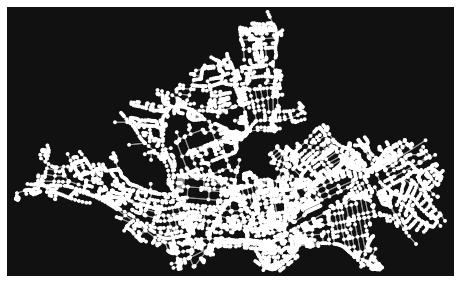

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [13]:
print(len(G.nodes), len(G.edges))
ox.plot_graph(G)

In [12]:
gedi = ox.utils_graph.get_digraph(G, weight='length')
gedi_from_old_build_graoh_approach = ox.utils_graph.get_digraph(graph, weight='length')


In [13]:
print(len(gedi.nodes), len(gedi.edges))
print(len(graph.nodes), len(graph.edges))
print(len(gedi_from_old_build_graoh_approach.nodes), len(gedi_from_old_build_graoh_approach.edges))


6731 14606
6731 14608
6731 14608


#### buildings

In [18]:
%%time


### Load bays
ways = session_osm.query(Way).filter(func.st_intersects(func.ST_GeomFromText(polygon.wkt, get_config_osm('srid')), Way.geometry)) 


graph = build_graph_from_ways(ways, polygon, False, False)

### Load buildings_w_a
buildings_w_a = session_osm.query(Buildings_with_Amenities).filter(func.st_intersects(func.ST_GeomFromText(polygon.wkt, get_config_osm('srid')), Buildings_with_Amenities.geometry_amenity)) 

### Load buildings_wo_a
buildings_wo_a = session_osm.query(Building_wo_Amenity).filter(func.st_intersects(func.ST_GeomFromText(polygon.wkt, get_config_osm('srid')), Building_wo_Amenity.geometry)) 

### Load buildings_wo_a
amenities_ni_Buildings = session_osm.query(Amenities_ni_Buildings).filter(func.st_intersects(func.ST_GeomFromText(polygon.wkt, get_config_osm('srid')), Amenities_ni_Buildings.geometry)) 




# start with amenities due to they have no shape, only a point, 
# thus, they are handled a ltiitle bit different
amenities_ni_Buildings_sql_df = pd.read_sql(
    amenities_ni_Buildings.statement,
    #con=session_osm.bind both ways are working. select the easier/ more appropriate one
    con=engine_osm
)

buildings_w_a_sql_df = pd.read_sql(
    buildings_w_a.statement,
    con=engine_osm
)

buildings_wo_a_sql_df = pd.read_sql(
    buildings_wo_a.statement,
    con=engine_osm
)


buildings_w_loads_df = parameterize_by_load_profiles(amenities_ni_Buildings_sql_df, buildings_w_a_sql_df, buildings_wo_a_sql_df)


events_venue is not matched in config and will be categorized as leftover
events_venue is not matched in config and will be categorized as leftover
Int64Index([6589915699, 2164602131, 3393042725], dtype='int64')
Wall time: 21.6 s


In [19]:
print(len(buildings_w_loads_df))
buildings_w_loads_df.capacity.sum()

12772


301675.050413364

In [20]:
301675.050413364 / 500

603.3501008267281

In [ ]:
buildings_w_loads_df.loc[buildings_w_loads_df.index==6496210741]['capacity'].values[0]

In [ ]:
buildings_w_loads_deprecated.loc[buildings_w_loads_deprecated.index==6496210741]['capacity'].values[0]

In [ ]:
abs(buildings_w_loads_df.loc[buildings_w_loads_df.index==6496210741]['capacity'].values[0] - buildings_w_loads_deprecated.loc[buildings_w_loads_deprecated.index==6496210741]['capacity'].values[0])

In [ ]:
buildings_w_loads_df[['category', 'area', 'capacity']].sort_values('capacity', ascending=False)